<a href="https://colab.research.google.com/github/satvik-dixit/explainability_ICASSP_2024/blob/main/Explainability_SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainability of DL-based embeddings




### Importing packages

In [ ]:

!git clone -q https://github.com/GasserElbanna/serab-byols.git
!python3 -m pip install -q -e ./serab-byols

!pip install -q tqdm==4.60.0
!pip install -q opensmile
!pip install -q lofo-importance

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 982.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# code to restart runtime so the packages get installed
import os
os.kill(os.getpid(), 9)

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from random import sample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import random
import torch
import opensmile
import serab_byols
import seaborn as sns

from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score, GroupShuffleSplit
from sklearn.metrics import classification_report, f1_score, make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
f1 = make_scorer(f1_score, average='weighted')

from lofo import LOFOImportance, Dataset, plot_importance
from lofo.flofo_importance import FLOFOImportance

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Upload kaggle.json to download the EmoDB dataset

! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Loading audio files and extracting metadata

Includes downloading the dataset, loading audio files, resampling audio files, extracting metadata



### Defining a function for loading and resampling audio files

In [ ]:
np.random.seed(42)

# Defining a function for loading and resampling audio files

def load_audio_files(audio_files, resampling_frequency=16000, audio_list=None):
  '''
  Loads and resamples audio files

  Parameters
  ------------
  audio_files: string
      The paths of the wav files
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''
  # Making audio_list
  if audio_list is None:
    audio_list = []

  # Resampling
  for audio in audio_files:
    signal, fs = librosa.load(audio, sr=resampling_frequency)
    audio_list.append(torch.from_numpy(signal))

  return audio_list


### Loading and resampling audiofiles and collecting metadata on EmoDB dataset

In [ ]:
# Load dataset
! kaggle datasets download -q -d piyushagni5/berlin-database-of-emotional-speech-emodb
! unzip -q berlin-database-of-emotional-speech-emodb.zip

# Load and resample audio files
audio_files = glob(os.path.join('/content/wav','*.wav'))
audio_list= load_audio_files(audio_files, resampling_frequency=16000)

# Making speakers list and labels list
speakers = []
labels = []
for audio_file in audio_files:
  file_name = audio_file.split('/')[3]
  speakers.append(int(file_name[:2]))
  labels.append(file_name[5:6])

label_dict = {'A': 'fear', 'L': 'boredom', 'E': 'disgust', 'T': 'sadness', 'W': 'anger', 'N': 'neutral', 'F': 'happiness'}
labels = [label_dict[emotion] for emotion in labels]

# Verify
print('Number of audio files: {}'.format(len(audio_list)))
print('Number of speaker classes: {}'.format(len(set(speakers))))
print('Speaker classes: {}'.format(set(speakers)))
print('Number of speakers: {}'.format(len(speakers)))
print('Number of label classes: {}'.format(len(set(labels))))
print('Label classes: {}'.format(set(labels)))
print('Number of labels: {}'.format(len(labels)))


Number of audio files: 535
Number of speaker classes: 10
Speaker classes: {3, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Number of speakers: 535
Number of label classes: 7
Label classes: {'happiness', 'sadness', 'boredom', 'fear', 'neutral', 'anger', 'disgust'}
Number of labels: 535


## Embedding Extraction
Includes extracting features using
- Deep learning based methods: Hybrid BYOL-S
- DSP based methods: openSMILE eGeMAPS

### Audio embeddings extraction functions

In [ ]:
# Defining a function for generating audio embedding extraction models

def audio_embeddings_model(model_name):
  '''
  Generates model for embedding extraction

  Parameters
  ------------
  mode_name: string
      The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'

  Returns
  ------------
  model: object
      The embedding extraction model
  '''
  if model_name=='hybrid_byols':
    model_name = 'cvt'
    checkpoint_path = "serab-byols/checkpoints/cvt_s1-d1-e64_s2-d1-e256_s3-d1-e512_BYOLAs64x96-osandbyolaloss6373-e100-bs256-lr0003-rs42.pth"
    model = serab_byols.load_model(checkpoint_path, model_name)
  elif model_name=='compare':
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
  elif model_name=='egemaps':
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
  return model


# Defining a function for embedding exctraction from the audio list

def audio_embeddings(audio_list, model_name, model, sampling_rate=16000):
  '''
  Loads and resamples audio files

  Parameters
  ------------
  audio_list: list
      A list of arrays, one array for each audio file
  model_name: string
      The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'
  model: object
      The embedding extraction model generated by audio_embeddings_model function
  sampling_rate: int
      The sampling rate, 16 kHz by default

  Returns
  ------------
  embeddings_array: array
      The array containg embeddings of all audio_files, dimension (number of audio files × n_feats)

  '''
  if model_name=='hybrid_byols':
    embeddings_array = serab_byols.get_scene_embeddings(audio_list, model)
  else:
    embeddings_list = []
    for i in tqdm(range(len(audio_list))):
      embeddings = model.process_signal(audio_list[i], sampling_rate)
      embeddings_list.append(torch.tensor(embeddings.values[0], dtype=torch.float32))
    embeddings_array = torch.stack(embeddings_list)
  return embeddings_array


def get_egemaps_feature_names():
  model = opensmile.Smile(
      feature_set=opensmile.FeatureSet.eGeMAPSv02,
      feature_level=opensmile.FeatureLevel.Functionals,
  )
  egemaps_feature_names = model.column_names
  return egemaps_feature_names



### Audio embeddings extraction on EmoDB

In [ ]:

# Hybrid BYOLS
model = audio_embeddings_model(model_name='hybrid_byols')
embeddings_array_byols = audio_embeddings(audio_list, model_name='hybrid_byols', model=model)

# EmoDB egemaps
model = audio_embeddings_model(model_name='egemaps')
embeddings_array_egemaps = audio_embeddings(audio_list, model_name='egemaps', model=model)

# ---------------------------------------------------------------------------------------------------

egemaps_feature_names = get_egemaps_feature_names()

# Verify Phase_2
models = ['hybrid_byols', 'egemaps']
embeddings_arrays = {'hybrid_byols': embeddings_array_byols, 'egemaps':embeddings_array_egemaps}

for model in models:
  print()
  print()
  print('MODEL: {}'.format(model))
  print()
  print('The shape of the embeddings array is {}'.format(embeddings_arrays[model].shape))
  print('The embeddings array is: ')
  print((embeddings_arrays[model]))


100%|██████████| 535/535 [01:07<00:00,  7.90it/s]




MODEL: hybrid_byols

The shape of the embeddings array is torch.Size([535, 2048])
The embeddings array is: 
tensor([[ 5.3388,  3.7416,  0.0901,  ...,  4.1878, -0.3355,  3.4405],
        [ 5.5285,  3.9728,  1.5190,  ...,  3.4509, -0.8364,  3.1530],
        [ 5.3639,  2.8612,  1.1415,  ...,  4.2140, -0.1698,  3.7697],
        ...,
        [ 4.7751,  4.0442,  1.8632,  ...,  4.8324, -0.5717,  3.6120],
        [ 4.9625,  8.1942,  0.5096,  ...,  5.4140, -1.4742,  3.7767],
        [ 6.2728,  5.1548,  1.9290,  ...,  4.8741, -1.0534,  3.5530]])


MODEL: egemaps

The shape of the embeddings array is torch.Size([535, 88])
The embeddings array is: 
tensor([[ 3.2742e+01,  9.1252e-02,  3.0648e+01,  ...,  1.0200e-01,
          5.2498e-02, -1.7506e+01],
        [ 3.9716e+01,  1.1470e-01,  3.6843e+01,  ...,  8.8571e-02,
          2.8997e-02, -1.9788e+01],
        [ 3.5476e+01,  7.3432e-02,  3.3470e+01,  ...,  8.8571e-02,
          3.4405e-02, -1.1847e+01],
        ...,
        [ 4.0609e+01,  6.5613e-

## Classification and Feature Importance Functions


In [ ]:
# function for dividing the dataset into dictionaries with emotions as keys and embeddings/labels/speakers as values

def label_division(embeddings_array, labels, required_labels, speakers):
    final_embeddings_dict = {}
    final_labels_dict = {}
    final_speakers_list_dict = {}

    for label in required_labels:
        label_indices = np.where(np.array(labels) == label)[0]
        label_embeddings = embeddings_array[label_indices, :]
        final_speakers_list_dict[label] = list(np.array(speakers)[label_indices])
        final_embeddings_dict[label] = label_embeddings
        final_labels_dict[label] = [label] * len(label_indices)

    return final_embeddings_dict, final_labels_dict, final_speakers_list_dict


In [ ]:
# function for combining one emotion (50%) and the rest of the 5 emotions (10% each)

def emotion_all_merger(emotion, other_emotions, embeddings_dict, speakers_dict, num=45):

  np.random.seed(42)

  emo_indices = np.random.choice(len(speakers_dict[emotion]), size=num, replace=False)

  embeddings = embeddings_dict[emotion][emo_indices]
  speakers = [speakers_dict[emotion][i] for i in emo_indices]
  labels = [1]*num

  for em in other_emotions:
    em_indices = np.random.choice(len(speakers_dict[em]), size=int(num/len(other_emotions)), replace=False)
    em_speakers = [speakers_dict[em][i] for i in em_indices]
    embeddings_e = embeddings_dict[em][em_indices]

    embeddings = np.concatenate((embeddings, embeddings_e), axis=0)
    speakers = speakers + em_speakers
    labels = labels + [0]*int(num/len(other_emotions))

  return embeddings, labels, speakers


In [ ]:
# Function for ranking all features in decreasing order of feature importance using permutation importance

def permutation_importance_method(X, y, feature_names):
  model = KNeighborsClassifier()
  model.fit(X, y)
  results = permutation_importance(model, X, y, scoring=f1, n_repeats=10, random_state=42)
  importances = results.importances_mean
  importance_list = [(feature_names[idx], importance) for idx, importance in enumerate(importances)]
  sorted_importances = sorted(importance_list, key=lambda x: x[1], reverse=True)
  return sorted_importances


In [ ]:
# Function for ranking all features in decreasing order of feature importance using coefficients

def feature_importance_method(X, y, feature_names, trained_model):
  coef_abs = abs(trained_model.coef_[0])
  feature_indices = np.argsort(coef_abs)[::-1]
  sorted_importances = [(feature_names[i], coef_abs[i]) for i in feature_indices]
  return sorted_importances


In [ ]:
# Function for nested cross validation

emotions = ['anger', 'fear', 'neutral', 'happiness', 'sadness', 'disgust']
Performance ={'eGeMAPS':{e:[] for e in emotions}, 'Hybrid_BYOL-S_2048':{e:[] for e in emotions}, 'Hybrid_BYOL-S_top_features':{e:[] for e in emotions}}

def classification_pipeline(embeddings, speakers, labels_list, feature_names):

    np.random.seed(42)

    X = embeddings
    y = labels_list
    groups = speakers

    # Define the hyperparameter grid for GridSearchCV
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

    # Outer cross-validation loop
    # outer_cv = GroupShuffleSplit(n_splits=2, train_size=0.7, random_state=42)
    outer_cv = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42)
    outer_scores = []
    feats_array = []
    for train_index, test_index in outer_cv.split(X, y, groups):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

        # Inner cross-validation loop for hyperparameter tuning
        inner_cv = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42) # 3 could also work
        grid_search = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=inner_cv)
        grid_search.fit(X_train, y_train, groups=[groups[i] for i in train_index])

        # Get the best hyperparameters found in the inner loop
        best_params = grid_search.best_params_

        # Fit the model with the best hyperparameters on the training data
        model = LogisticRegression(solver='lbfgs', **best_params)

        # Standardize X_train and transform X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='binary') # change to binary
        outer_scores.append(score)

    # Compute and print the mean F1 score across all outer folds
    mean_f1 = np.round(np.mean(outer_scores), 3)
    return model, 100*mean_f1



In [ ]:
from pandas.core import groupby
# Function for using LOFO

def lofo_plot(embeddings_array, labels, feature_names, frac, e, auto_group_threshold=0.8):

  y=labels

  df = pd.DataFrame(embeddings_array)
  df.columns = feature_names
  df['Results'] = y

  sample_df = df.sample(frac=frac, random_state=42)
  cv = KFold(n_splits=5, shuffle=True, random_state=42)# groupshuffle split will ask for specifying groups - figure out how
  dataset = Dataset(df=sample_df, target='Results', features=feature_names, auto_group_threshold=auto_group_threshold)

  model = LogisticRegression() # put best parameters here

  lofo_imp = LOFOImportance(dataset=dataset, scoring="f1", model=model, fit_params=None, cv=cv)
  importance_df = lofo_imp.get_importance()

  return importance_df


In [ ]:
def find_x_at_n_percentile(x_values, y_values, n):
    percentile = np.percentile(y_values, n)
    for i, y in enumerate(y_values):
        if y >= percentile:
            x_at_nth_percentile = x_values[i]
            break

    return x_at_nth_percentile

# eGeMAPS

In [ ]:
eGeMAPS_embeddings_dict, eGeMAPS_labels_dict, eGeMAPS_speakers_list_dict = label_division(embeddings_array=embeddings_array_eGeMAPS, labels=labels, required_labels=['anger', 'fear', 'neutral', 'happiness', 'sadness', 'disgust'], speakers=speakers)


In [ ]:
print(eGeMAPS_embeddings_dict)
print(eGeMAPS_labels_dict)
print(eGeMAPS_speakers_list_dict)

{'anger': tensor([[ 3.9716e+01,  1.1470e-01,  3.6843e+01,  ...,  8.8571e-02,
          2.8997e-02, -1.9788e+01],
        [ 3.7811e+01,  1.2929e-01,  3.4489e+01,  ...,  9.0000e-02,
          4.5461e-02, -1.6709e+01],
        [ 4.1080e+01,  1.1140e-01,  3.7923e+01,  ...,  4.4000e-02,
          1.4967e-02, -1.8816e+01],
        ...,
        [ 4.1057e+01,  7.6373e-02,  3.9441e+01,  ...,  7.1429e-02,
          2.9966e-02, -1.5695e+01],
        [ 3.5205e+01,  1.4895e-01,  3.0809e+01,  ...,  1.2091e-01,
          5.5833e-02, -2.0696e+01],
        [ 4.0609e+01,  6.5613e-02,  3.9180e+01,  ...,  7.7778e-02,
          5.0504e-02, -1.8922e+01]]), 'fear': tensor([[ 3.2742e+01,  9.1252e-02,  3.0648e+01,  ...,  1.0200e-01,
          5.2498e-02, -1.7506e+01],
        [ 3.2487e+01,  1.2997e-01,  2.9262e+01,  ...,  1.1429e-01,
          3.2451e-02, -1.8617e+01],
        [ 3.3211e+01,  9.6890e-02,  3.0522e+01,  ...,  1.0143e-01,
          9.4177e-02, -1.5007e+01],
        ...,
        [ 3.3693e+01,  5.12

anger
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F1amplitudeLogRelF0_sma3nz_amean', 'F1amplitudeLogRelF0_sma3nz_stddevNorm', 'F1frequency_sma3nz_amean', 'F2amplitudeLogRelF0_sma3nz_amean', 'F2amplitudeLogRelF0_sma3nz_stddevNorm', 'F2frequency_sma3nz_amean', 'F3amplitudeLogRelF0_sma3nz_amean', 'F3amplitudeLogRelF0_sma3nz_stddevNorm', 'F3frequency_sma3nz_amean', 'MeanUnvoicedSegmentLength', 'StddevUnvoicedSegmentLength', 'alphaRatioV_sma3nz_amean', 'hammarbergIndexV_sma3nz_amean', 'hammarbergIndexV_sma3nz_stddevNorm', 'logRelF0-H1-A3_sma3nz_amean', 'logRelF0-H1-A3_sma3nz_stddevNorm', 'mfcc1V_sma3nz_amean', 'mfcc1_sma3_amean', 'mfcc2V_sma3nz_amean', 'mfcc2_sma3_amean', 'mfcc3V_sma3nz_amean', 'mfcc3_sma3_amean', 'mfcc4V_sma3nz_amean', 'mfcc

  0%|          | 0/51 [00:00<?, ?it/s]



fear
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'mfcc3V_sma3nz_amean', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm']
2 ['F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope']
3 ['loudness_sma3_amean', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0']
4 ['spectralFluxV_sma3nz_amean', 'spectralFlux_sma3_amean']
5 ['spectralFluxV_sma3nz_stddevNorm', 'spectralFlux_sma3_stddevNorm']
6 ['logRelF0-H1-A3_sma3nz_amean', 'logRelF0-H1-A3_sma3nz_stddevNorm', 'mfcc1V_sma3nz_amean', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm']
7 ['alphaRatioV_sma3nz_amean', 'alphaRatioV_sma3nz_stddevNorm', 'hammarbergIndexV_sma3nz_amean', 'hammarbergIndexV_sma3nz_stddevNorm', 'mfcc2V_sma3nz_amean', 'mfcc2_sma3_am

  0%|          | 0/54 [00:00<?, ?it/s]



neutral
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0']
2 ['F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope']
3 ['loudness_sma3_amean', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0']
4 ['spectralFluxUV_sma3nz_amean', 'spectralFluxV_sma3nz_amean', 'spectralFlux_sma3_amean']
5 ['spectralFluxV_sma3nz_stddevNorm', 'spectralFlux_sma3_stddevNorm']
6 ['alphaRatioV_sma3nz_amean', 'alphaRatioV_sma3nz_stddevNorm', 'hammarbergIndexV_sma3nz_amean', 'hammarbergIndexV_sma3nz_stddevNorm', 'logRelF0-H1-A3_sma3nz_amean', 'logRelF0-H1-A3_sma3nz_stddevNorm', 'mfcc1V_sma3nz_amean', 'mfcc1V_sma3nz_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2V_sma3nz_a

  0%|          | 0/53 [00:00<?, ?it/s]



happiness
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F1amplitudeLogRelF0_sma3nz_amean', 'F1amplitudeLogRelF0_sma3nz_stddevNorm', 'F2amplitudeLogRelF0_sma3nz_amean', 'F2amplitudeLogRelF0_sma3nz_stddevNorm', 'F3amplitudeLogRelF0_sma3nz_amean', 'F3amplitudeLogRelF0_sma3nz_stddevNorm', 'MeanUnvoicedSegmentLength', 'StddevUnvoicedSegmentLength', 'alphaRatioV_sma3nz_amean', 'alphaRatioV_sma3nz_stddevNorm', 'hammarbergIndexV_sma3nz_amean', 'hammarbergIndexV_sma3nz_stddevNorm', 'logRelF0-H1-A3_sma3nz_amean', 'logRelF0-H1-A3_sma3nz_stddevNorm', 'mfcc1V_sma3nz_amean', 'mfcc1V_sma3nz_stddevNorm', 'mfcc1_sma3_amean', 'mfcc2V_sma3nz_amean', 'mfcc2_sma3_amean', 'mfcc3V_sma3nz_amean', 'mfcc3_sma3_amean', 'mfcc4V_sma3nz_amean', 'mfcc4_sma3_amean', 's

  0%|          | 0/50 [00:00<?, ?it/s]



sadness
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0']
2 ['F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope']
3 ['loudness_sma3_amean', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0']
4 ['spectralFluxUV_sma3nz_amean', 'spectralFluxV_sma3nz_amean', 'spectralFlux_sma3_amean']
5 ['spectralFluxV_sma3nz_stddevNorm', 'spectralFlux_sma3_stddevNorm']
6 ['mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm']
7 ['F1amplitudeLogRelF0_sma3nz_amean', 'F1amplitudeLogRelF0_sma3nz_stddevNorm', 'F2amplitudeLogRelF0_sma3nz_amean', 'F2amplitudeLogRelF0_sma3nz_stddevNorm', 'F3amplitudeLogRelF0_sma3nz_amean', 'F3amplitudeLogRelF0_sma3nz_stddevNorm', 'MeanUnvoicedSegmentLength', 'St

  0%|          | 0/51 [00:00<?, ?it/s]



disgust
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'alphaRatioV_sma3nz_amean', 'hammarbergIndexV_sma3nz_amean', 'hammarbergIndexV_sma3nz_stddevNorm', 'logRelF0-H1-A3_sma3nz_amean', 'logRelF0-H1-A3_sma3nz_stddevNorm', 'mfcc1V_sma3nz_amean', 'mfcc1_sma3_amean', 'mfcc2V_sma3nz_amean', 'mfcc2_sma3_amean', 'mfcc3V_sma3nz_amean', 'mfcc3_sma3_amean', 'slopeUV0-500_sma3nz_amean', 'slopeV0-500_sma3nz_amean']
2 ['F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope']
3 ['loudness_sma3_amean', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0']
4 ['spectralFluxV_sma3nz_amean', 'spectralFlux_sma3_amean']
5 ['spectralFluxV_sma3nz_stddevNorm', 'spectralFlux_sma3_stddev

  0%|          | 0/55 [00:00<?, ?it/s]

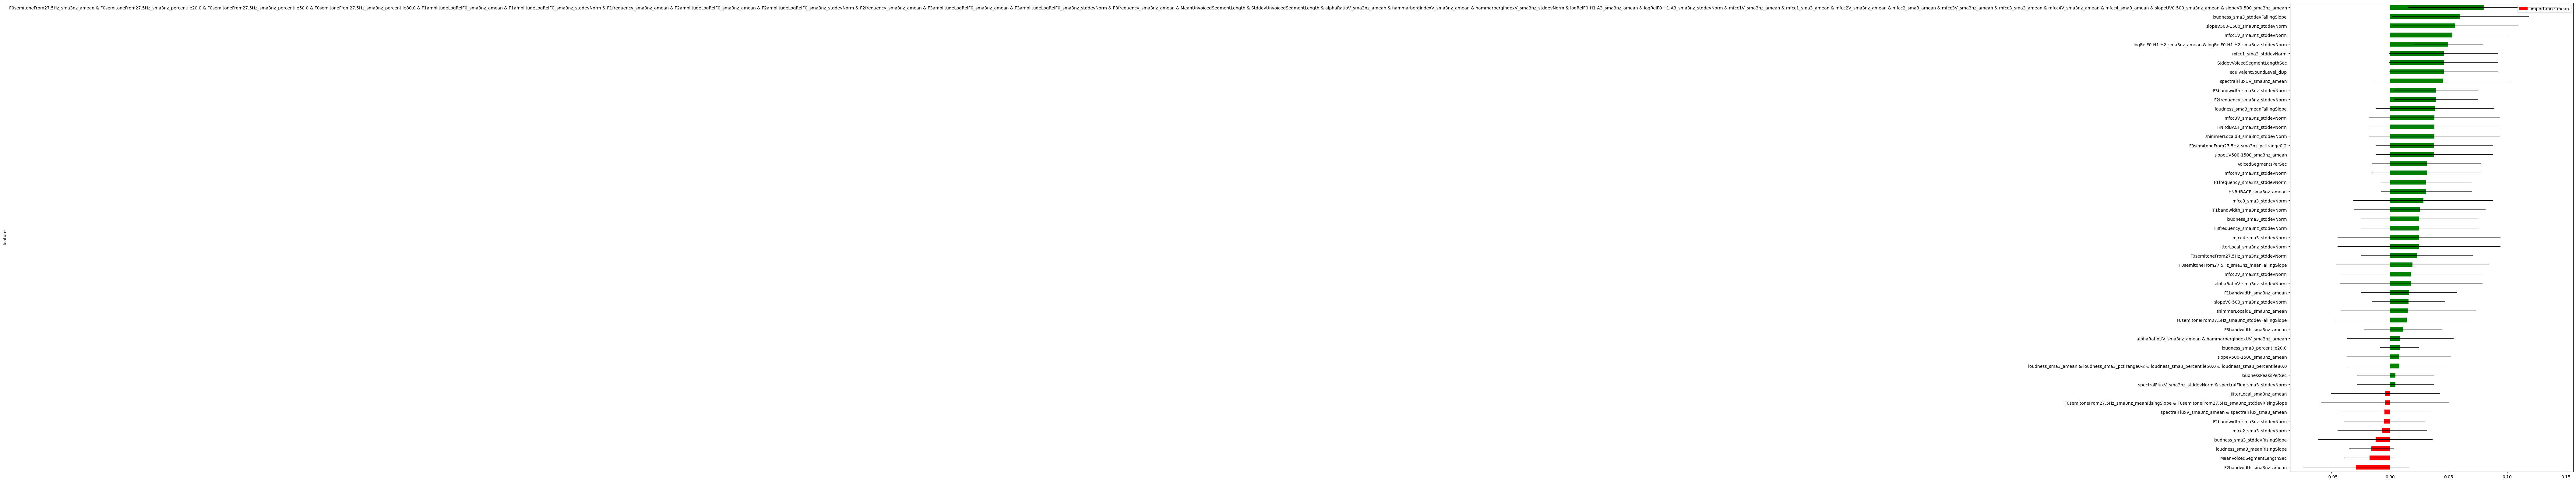

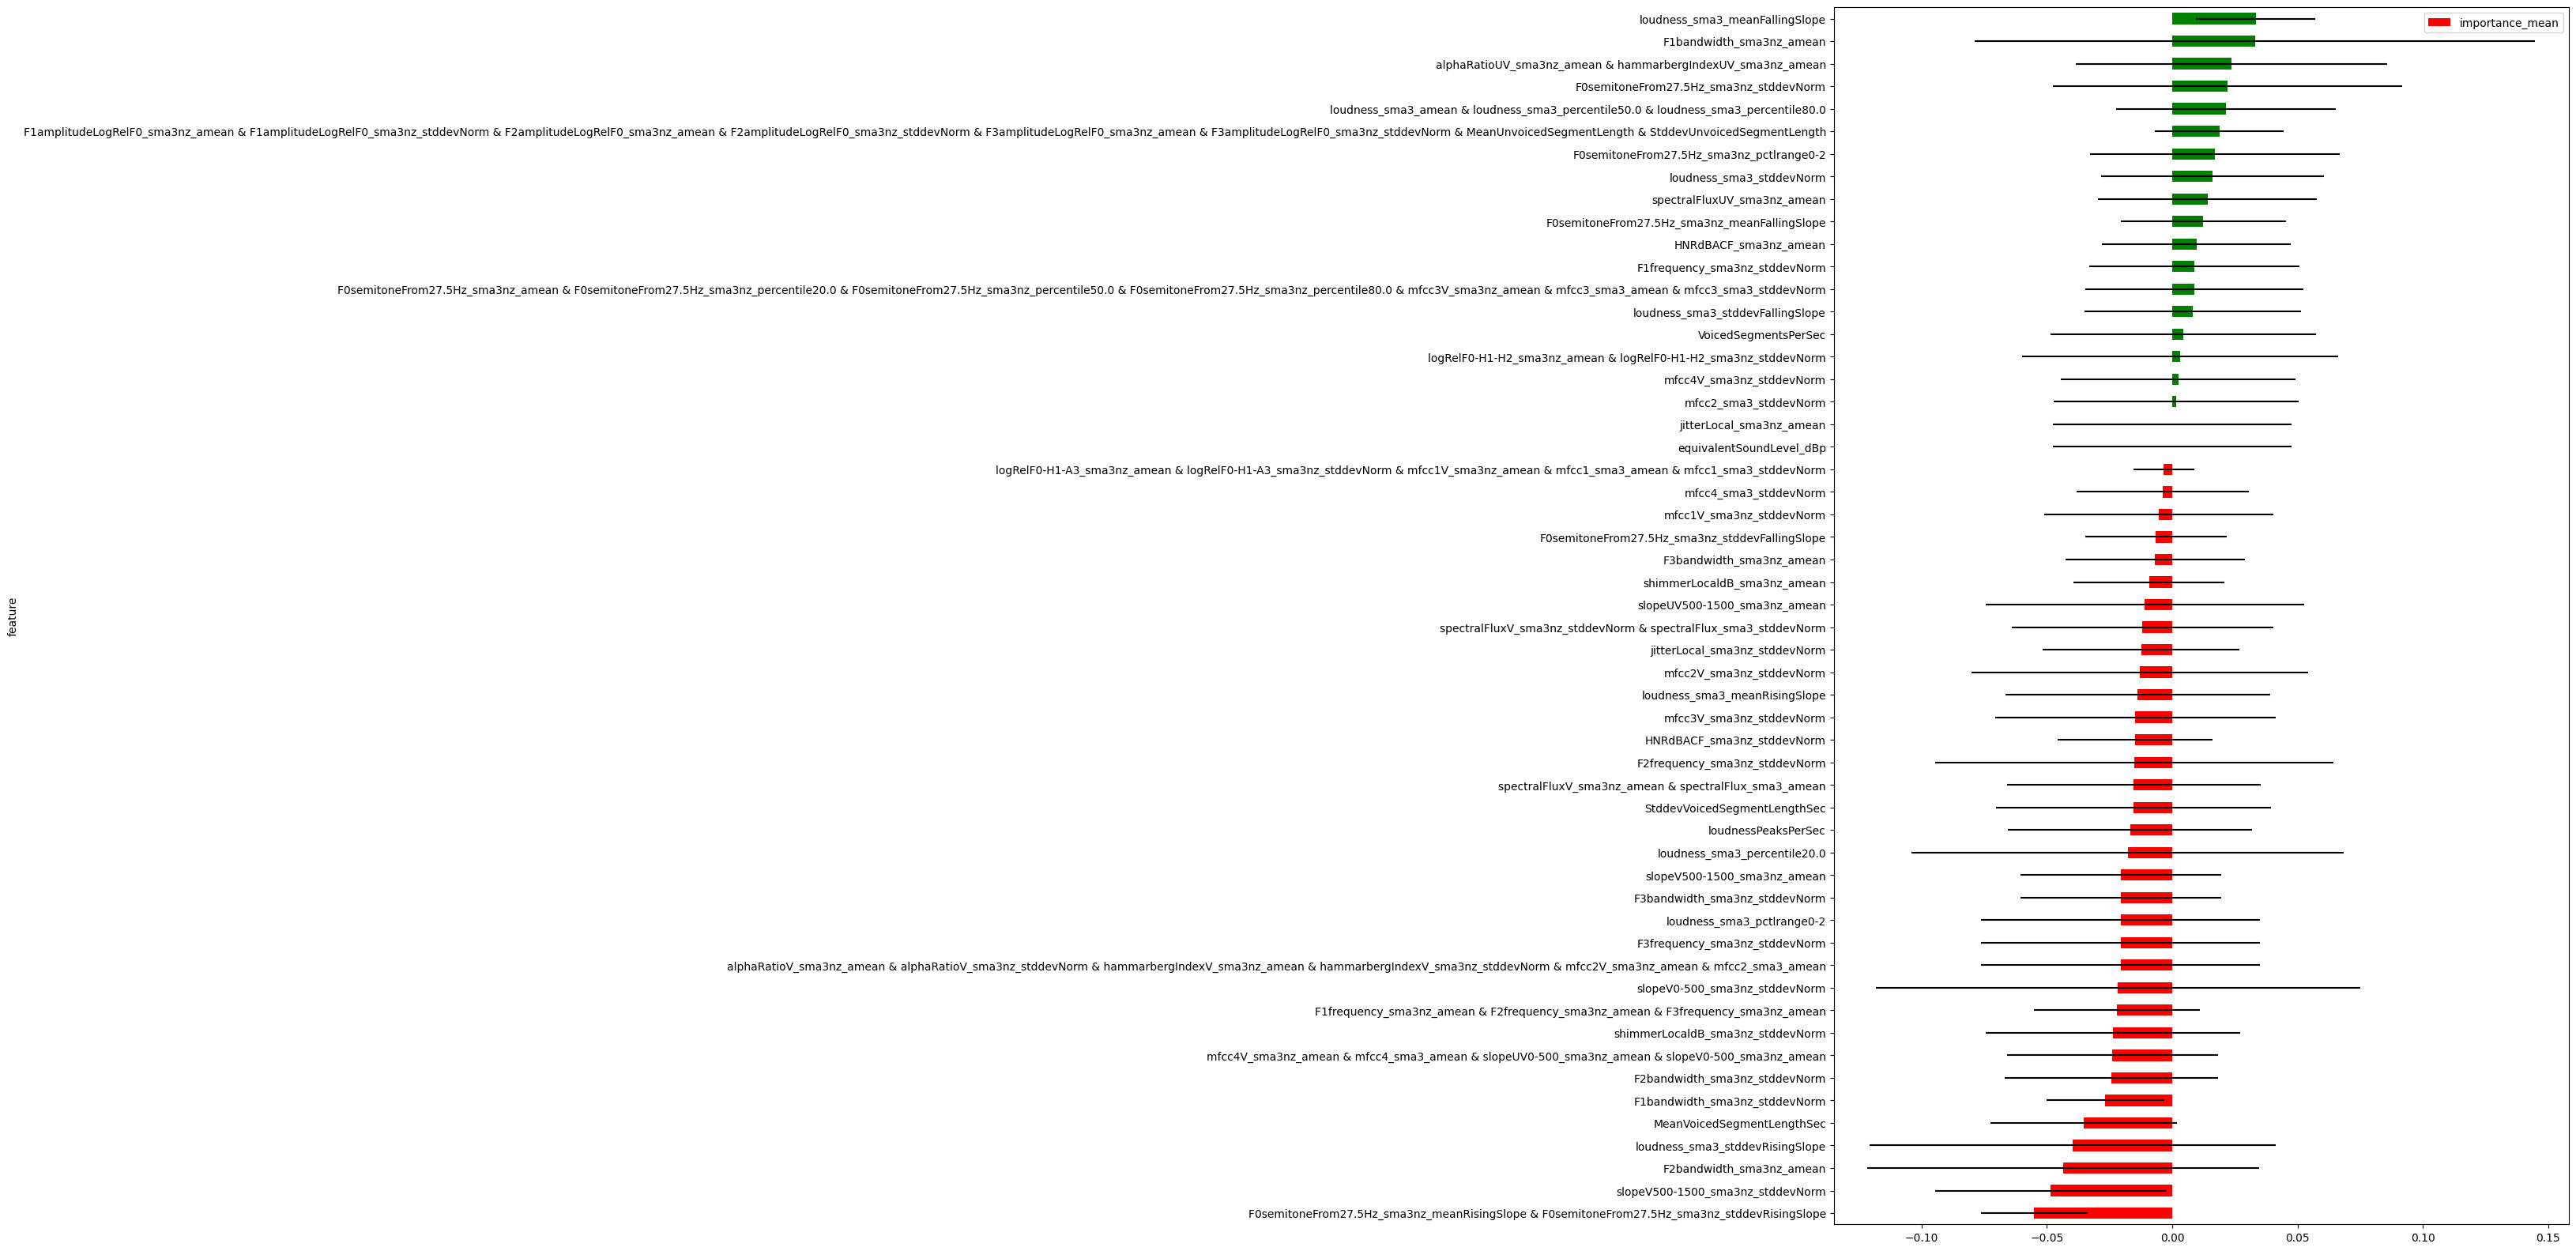

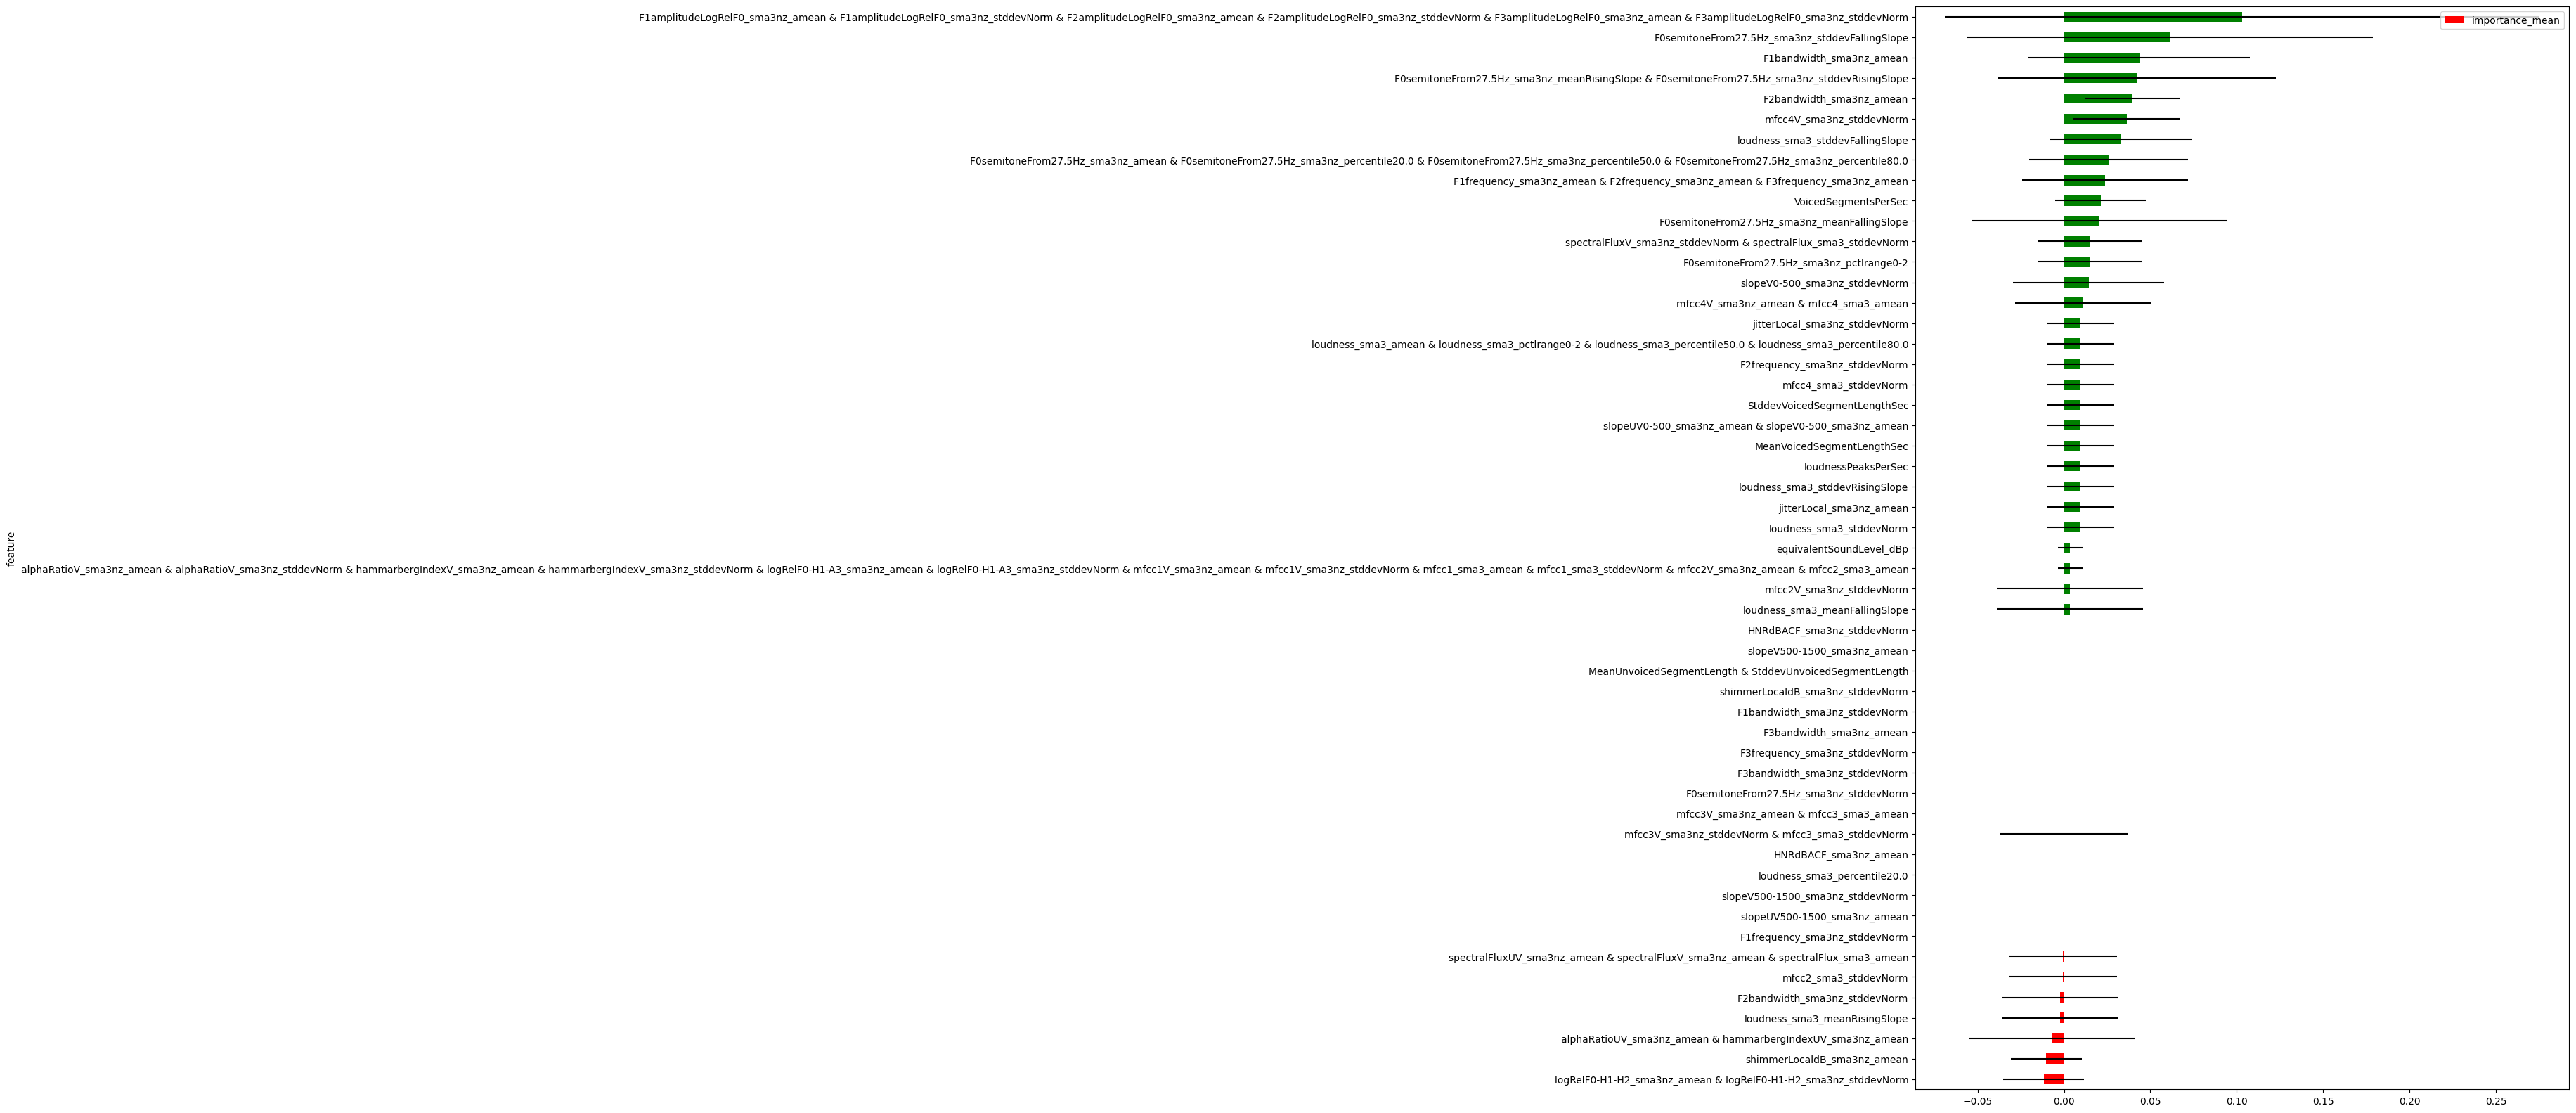

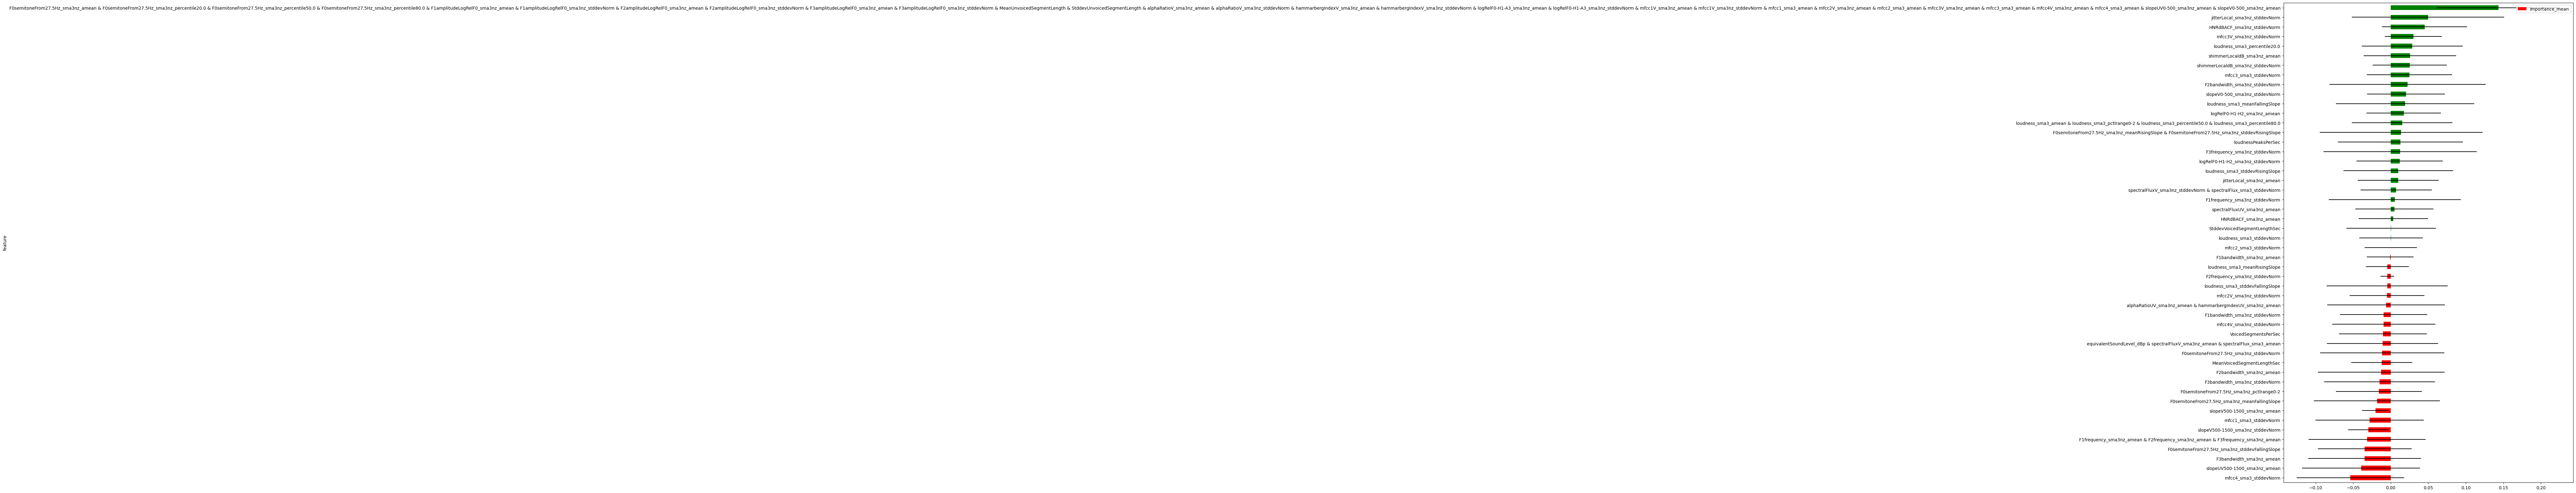

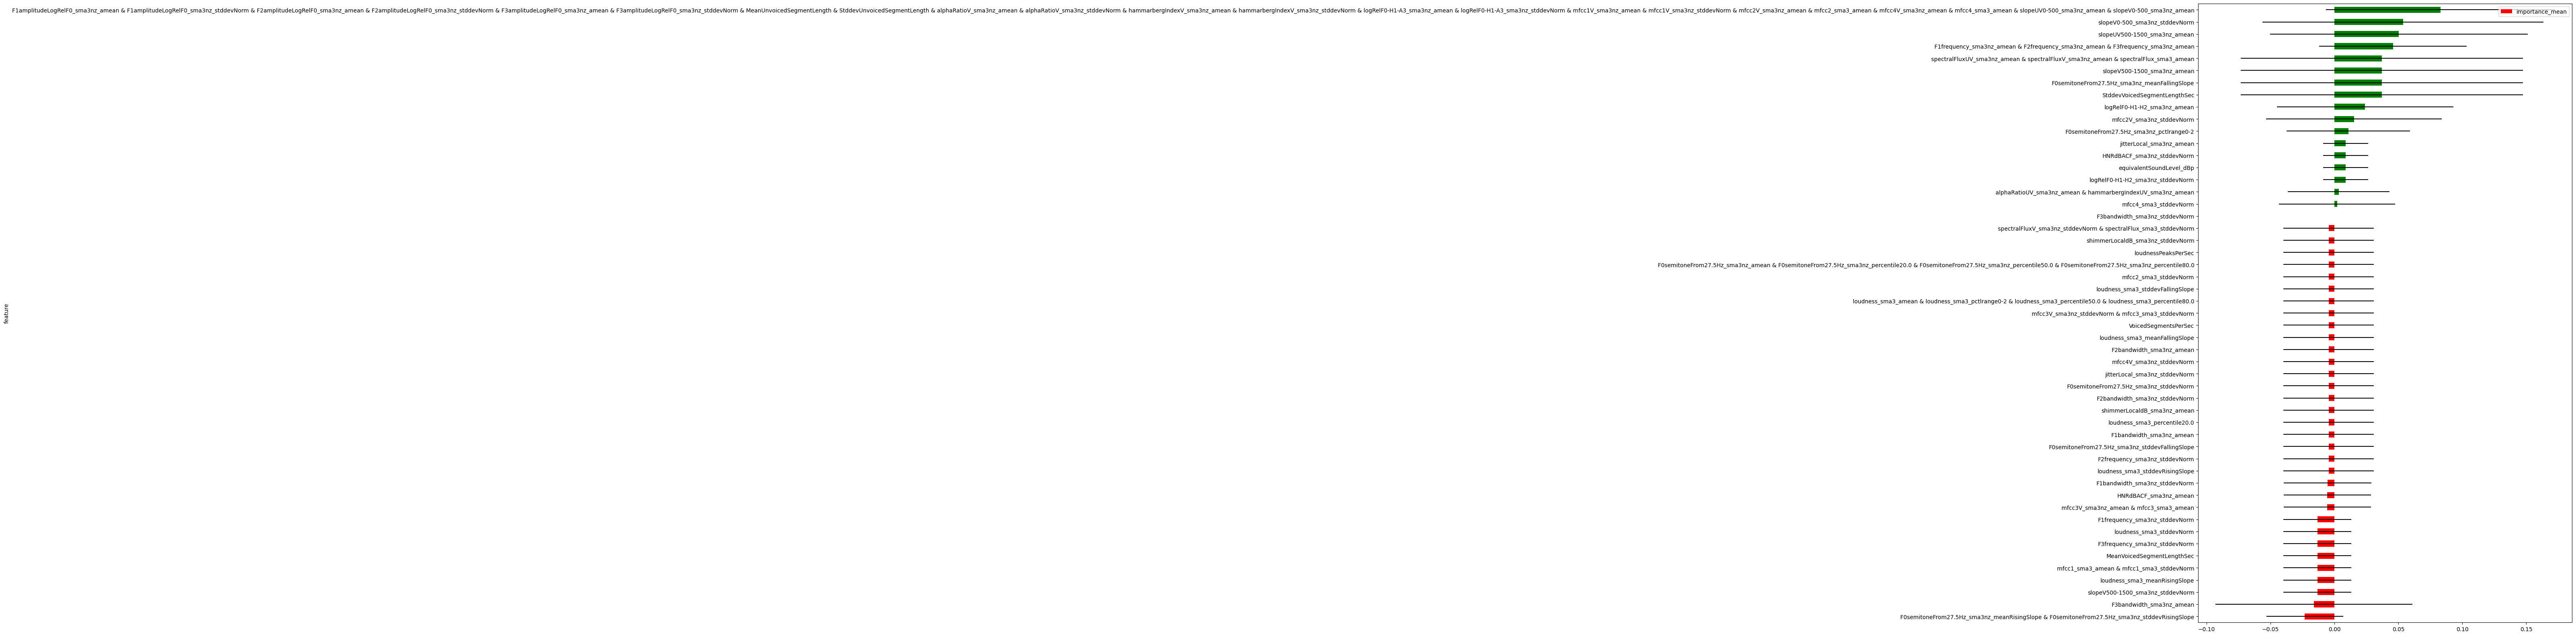

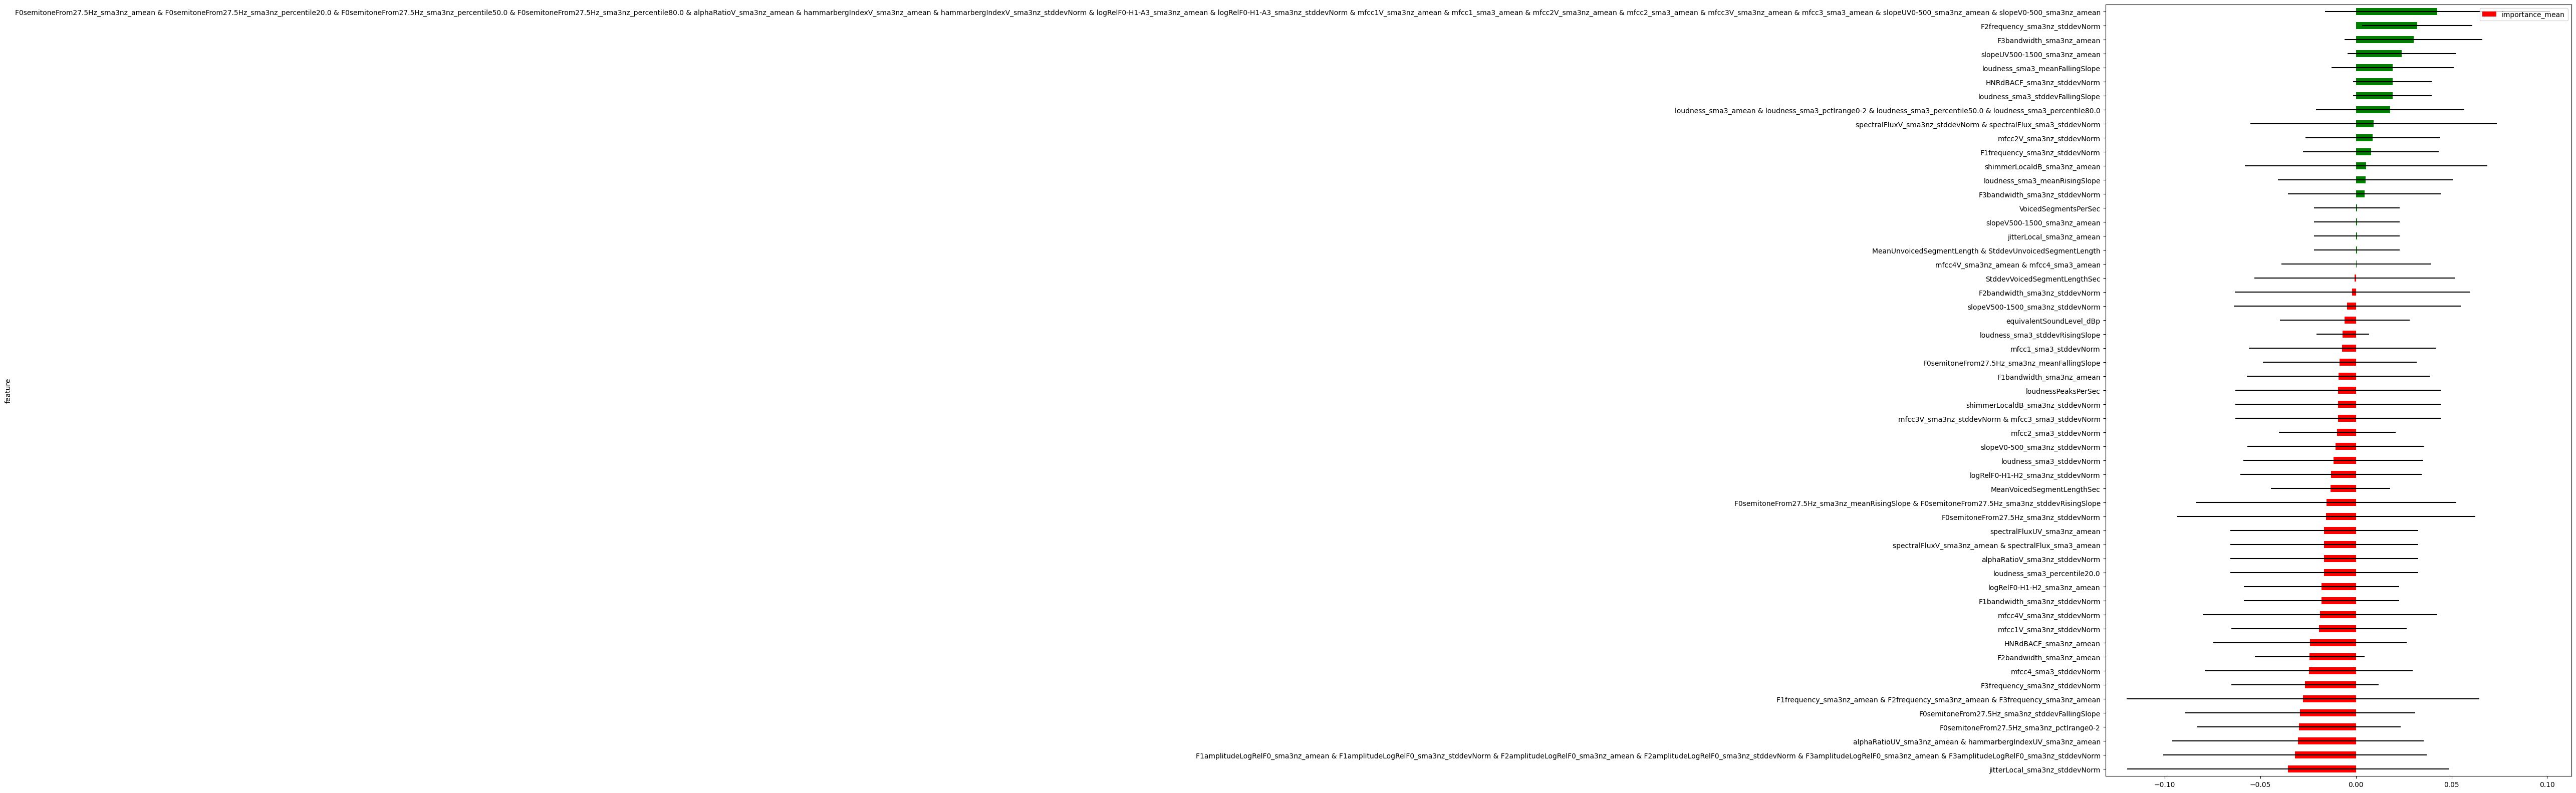

In [ ]:

eGeMAPS_fi_dict = {}
eGeMAPS_top_fi_features = {}
eGeMAPS_top_features = {}
lofo_dict = {}
emotions = ['anger', 'fear', 'neutral', 'happiness', 'sadness', 'disgust']

for e in emotions:

  print(e)
  print('---------------------------------------------------------------------')
  print()

  ege_embeddings, ege_labels, ege_speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], embeddings_dict=eGeMAPS_embeddings_dict, speakers_dict=eGeMAPS_speakers_list_dict, num=45)

  trained_model, result = classification_pipeline(embeddings=ege_embeddings, speakers=ege_speakers, labels_list=ege_labels, feature_names=eGeMAPS_feature_names)
  Performance['eGeMAPS'][e] = result

  fi = feature_importance_method(X=ege_embeddings, y=ege_labels, feature_names=eGeMAPS_feature_names, trained_model=trained_model)
  eGeMAPS_fi_dict[e] = [list(eGeMAPS_feature_names).index(tup[0]) for tup in fi]
  eGeMAPS_top_fi_features[e] = [tup[0] for tup in fi]

  lofo_df = lofo_plot(embeddings_array=ege_embeddings, labels=ege_labels, feature_names=eGeMAPS_feature_names, frac=1.0, e=e, auto_group_threshold=0.8)
  lofo_df.round(3)
  lofo_dict[e] = lofo_df

  # print(fi)
  print()
  print()


## Most important eGeMAPS features (according to LOFO )

In [ ]:
df = lofo_dict[emotions[0]].head(10)
df


feature  importance_mean  \
44  F0semitoneFrom27.5Hz_sma3nz_amean & F0semitone...         0.080298   
35                   loudness_sma3_stddevFallingSlope         0.060000   
3                    slopeV500-1500_sma3nz_stddevNorm         0.055612   
31                           mfcc1V_sma3nz_stddevNorm         0.053318   
49  logRelF0-H1-H2_sma3nz_amean & logRelF0-H1-H2_s...         0.049592   
22                              mfcc1_sma3_stddevNorm         0.045965   
37                       StddevVoicedSegmentLengthSec         0.045965   
14                           equivalentSoundLevel_dBp         0.045965   
15                        spectralFluxUV_sma3nz_amean         0.045318   
30                      F2frequency_sma3nz_stddevNorm         0.039298   

    importance_std  val_imp_0  val_imp_1  val_imp_2  val_imp_3  val_imp_4  
44        0.065056   0.051471   0.063158   0.196429   0.090435   0.000000  
35        0.058547   0.000000   0.133333   0.125000   0.000000   0.041667  
3         0.053947   0.051471   0.063158   0.125000  -0.040000   0.078431  
31        0.048065   0.000000   0.063158   0.125000   0.000000   0.078431  
49        0.029933   0.051471   0.063158   0.091667   0.000000   0.041667  
22        0.046446   0.000000   0.063158   0.125000   0.000000   0.041667  
37        0.046446   0.000000   0.063158   0.125000   0.000000   0.041667  
14        0.046446   0.000000   0.063158   0.125000   0.000000   0.041667  
15        0.058475   0.000000   0.063158   0.125000  -0.040000   0.078431  
30        0.035794   0.000000   0.063158   0.091667   0.000000   0.041667

In [ ]:
df = lofo_dict[emotions[1]].head(10)
df

In [ ]:
df = lofo_dict[emotions[2]].head(10)
df

In [ ]:
df = lofo_dict[emotions[3]].head(10)
df

In [ ]:
df = lofo_dict[emotions[4]].head(10)
df

In [ ]:
df = lofo_dict[emotions[5]].head(10)
df

# Hybrid BYOL-S

In [ ]:
BYOL-S_embeddings_dict, BYOL-S_labels_dict, BYOL-S_speakers_list_dict = label_division(embeddings_array=embeddings_array_BYOL-S, labels=labels, required_labels=['anger', 'fear', 'neutral', 'happiness', 'sadness', 'disgust'], speakers=speakers)


In [1]:
# print(BYOL-S_embeddings_dict)
# print(BYOL-S_labels_dict)
# print(BYOL-S_speakers_list_dict)

anger
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['1020', '1028', '1076', '1091', '111', '1372', '144', '1464', '152', '159', '169', '1766', '1924', '193', '197', '247', '259', '27', '273', '30', '305', '317', '358', '373', '375', '38', '383', '384', '385', '42', '447', '452', '476', '493', '500', '55', '575', '584', '590', '643', '652', '667', '688', '88', '937']
2 ['478', '64']
3 ['132', '431']
4 ['391', '396']
5 ['516', '860']
6 ['1169', '1459', '1971', '657', '947']
7 ['1260', '1772', '748']
8 ['1311', '1823', '799']
9 ['1447', '935']
10 ['1224', '1736']
11 ['1384', '1896']
12 ['1386', '1898']
13 ['1415', '1927']
14 ['1555', '1590']


  0%|          | 0/1986 [00:00<?, ?it/s]



fear
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['0', '1020', '1162', '1372', '144', '259', '27', '30', '306', '317', '373', '375', '452', '500', '508', '516', '575', '584', '590', '63', '652', '700', '78', '860', '88', '937']
2 ['197', '42']
3 ['358', '476', '55']
4 ['164', '676']
5 ['193', '385']
6 ['348', '482']
7 ['1098', '586']
8 ['1169', '1459', '1971', '657', '947']
9 ['1224', '1447', '1736', '712', '935']
10 ['1311', '1823', '799']
11 ['1384', '1896', '872']
12 ['1172', '1684']
13 ['1212', '1293']
14 ['1260', '1772']
15 ['1381', '1893']
16 ['1415', '1927']
17 ['1420', '1932']
18 ['1766', '1924']


  0%|          | 0/1997 [00:00<?, ?it/s]



neutral
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['0', '111', '1372', '144', '152', '27', '30', '313', '317', '35', '375', '38', '447', '500', '508', '516', '539', '575', '584', '590', '63', '652', '688', '764', '78', '781', '860', '88']
2 ['4', '68', '72']
3 ['146', '188']
4 ['1020', '373']
5 ['391', '396']
6 ['1098', '586']
7 ['1224', '1736', '712']
8 ['1302', '790']
9 ['1384', '872']
10 ['1447', '935']
11 ['1459', '947']
12 ['1053', '1399']
13 ['1293', '1443']
14 ['1392', '1904']
15 ['1415', '1927']


  0%|          | 0/2005 [00:00<?, ?it/s]



happiness
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['0', '78']
2 ['4', '72']
3 ['1020', '1028', '1076', '111', '1162', '1194', '1372', '144', '1464', '1504', '159', '177', '197', '27', '293', '30', '300', '305', '317', '373', '375', '391', '396', '42', '44', '500', '575', '590', '643', '652', '700', '878', '88']
4 ['358', '476', '55']
5 ['516', '860']
6 ['1098', '1610', '586']
7 ['1169', '1459', '1681', '1971', '657', '903', '947']
8 ['1224', '1447', '1736', '712', '935']
9 ['1260', '748']
10 ['1384', '1896', '872']
11 ['1411', '899']
12 ['1311', '1823']
13 ['1319', '1831']
14 ['1381', '1893']
15 ['1415', '1927']
16 ['1688', '1829']
17 ['1766', '1924']


  0%|          | 0/1989 [00:00<?, ?it/s]



sadness
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['0', '115', '1169', '1224', '125', '1302', '131', '1311', '140', '141', '1415', '1437', '144', '1447', '1459', '146', '148', '151', '1681', '169', '17', '1736', '177', '181', '1823', '188', '1927', '1959', '1971', '200', '248', '26', '27', '276', '280', '30', '306', '313', '317', '35', '358', '370', '38', '391', '396', '423', '447', '449', '476', '480', '488', '500', '501', '503', '506', '508', '516', '63', '652', '68', '700', '711', '712', '72', '78', '790', '799', '82', '860', '903', '904', '925', '935', '947']
2 ['422', '478', '64']
3 ['133', '81']
4 ['196', '269']
5 ['1039', '527']
6 ['539', '887']
7 ['1260', '1772', '748']
8 ['1384', '1896', '872']
9 ['1410', '1501']


  0%|          | 0/1964 [00:00<?, ?it/s]



disgust
---------------------------------------------------------------------

Automatically grouped features by correlation:
1 ['1020', '1076', '1162', '1372', '140', '144', '1464', '27', '30', '306', '313', '317', '373', '375', '38', '447', '452', '500', '501', '506', '508', '516', '575', '584', '590', '63', '652', '78', '860', '88']
2 ['197', '42']
3 ['193', '385']
4 ['1098', '586']
5 ['1103', '591']
6 ['1224', '1736', '712']
7 ['1260', '1772', '748']
8 ['1311', '1823', '799']
9 ['1384', '1896', '872']
10 ['1447', '935']
11 ['1056', '1568']
12 ['1212', '1293']
13 ['1415', '1927']
14 ['1729', '1918']


  0%|          | 0/2002 [00:00<?, ?it/s]

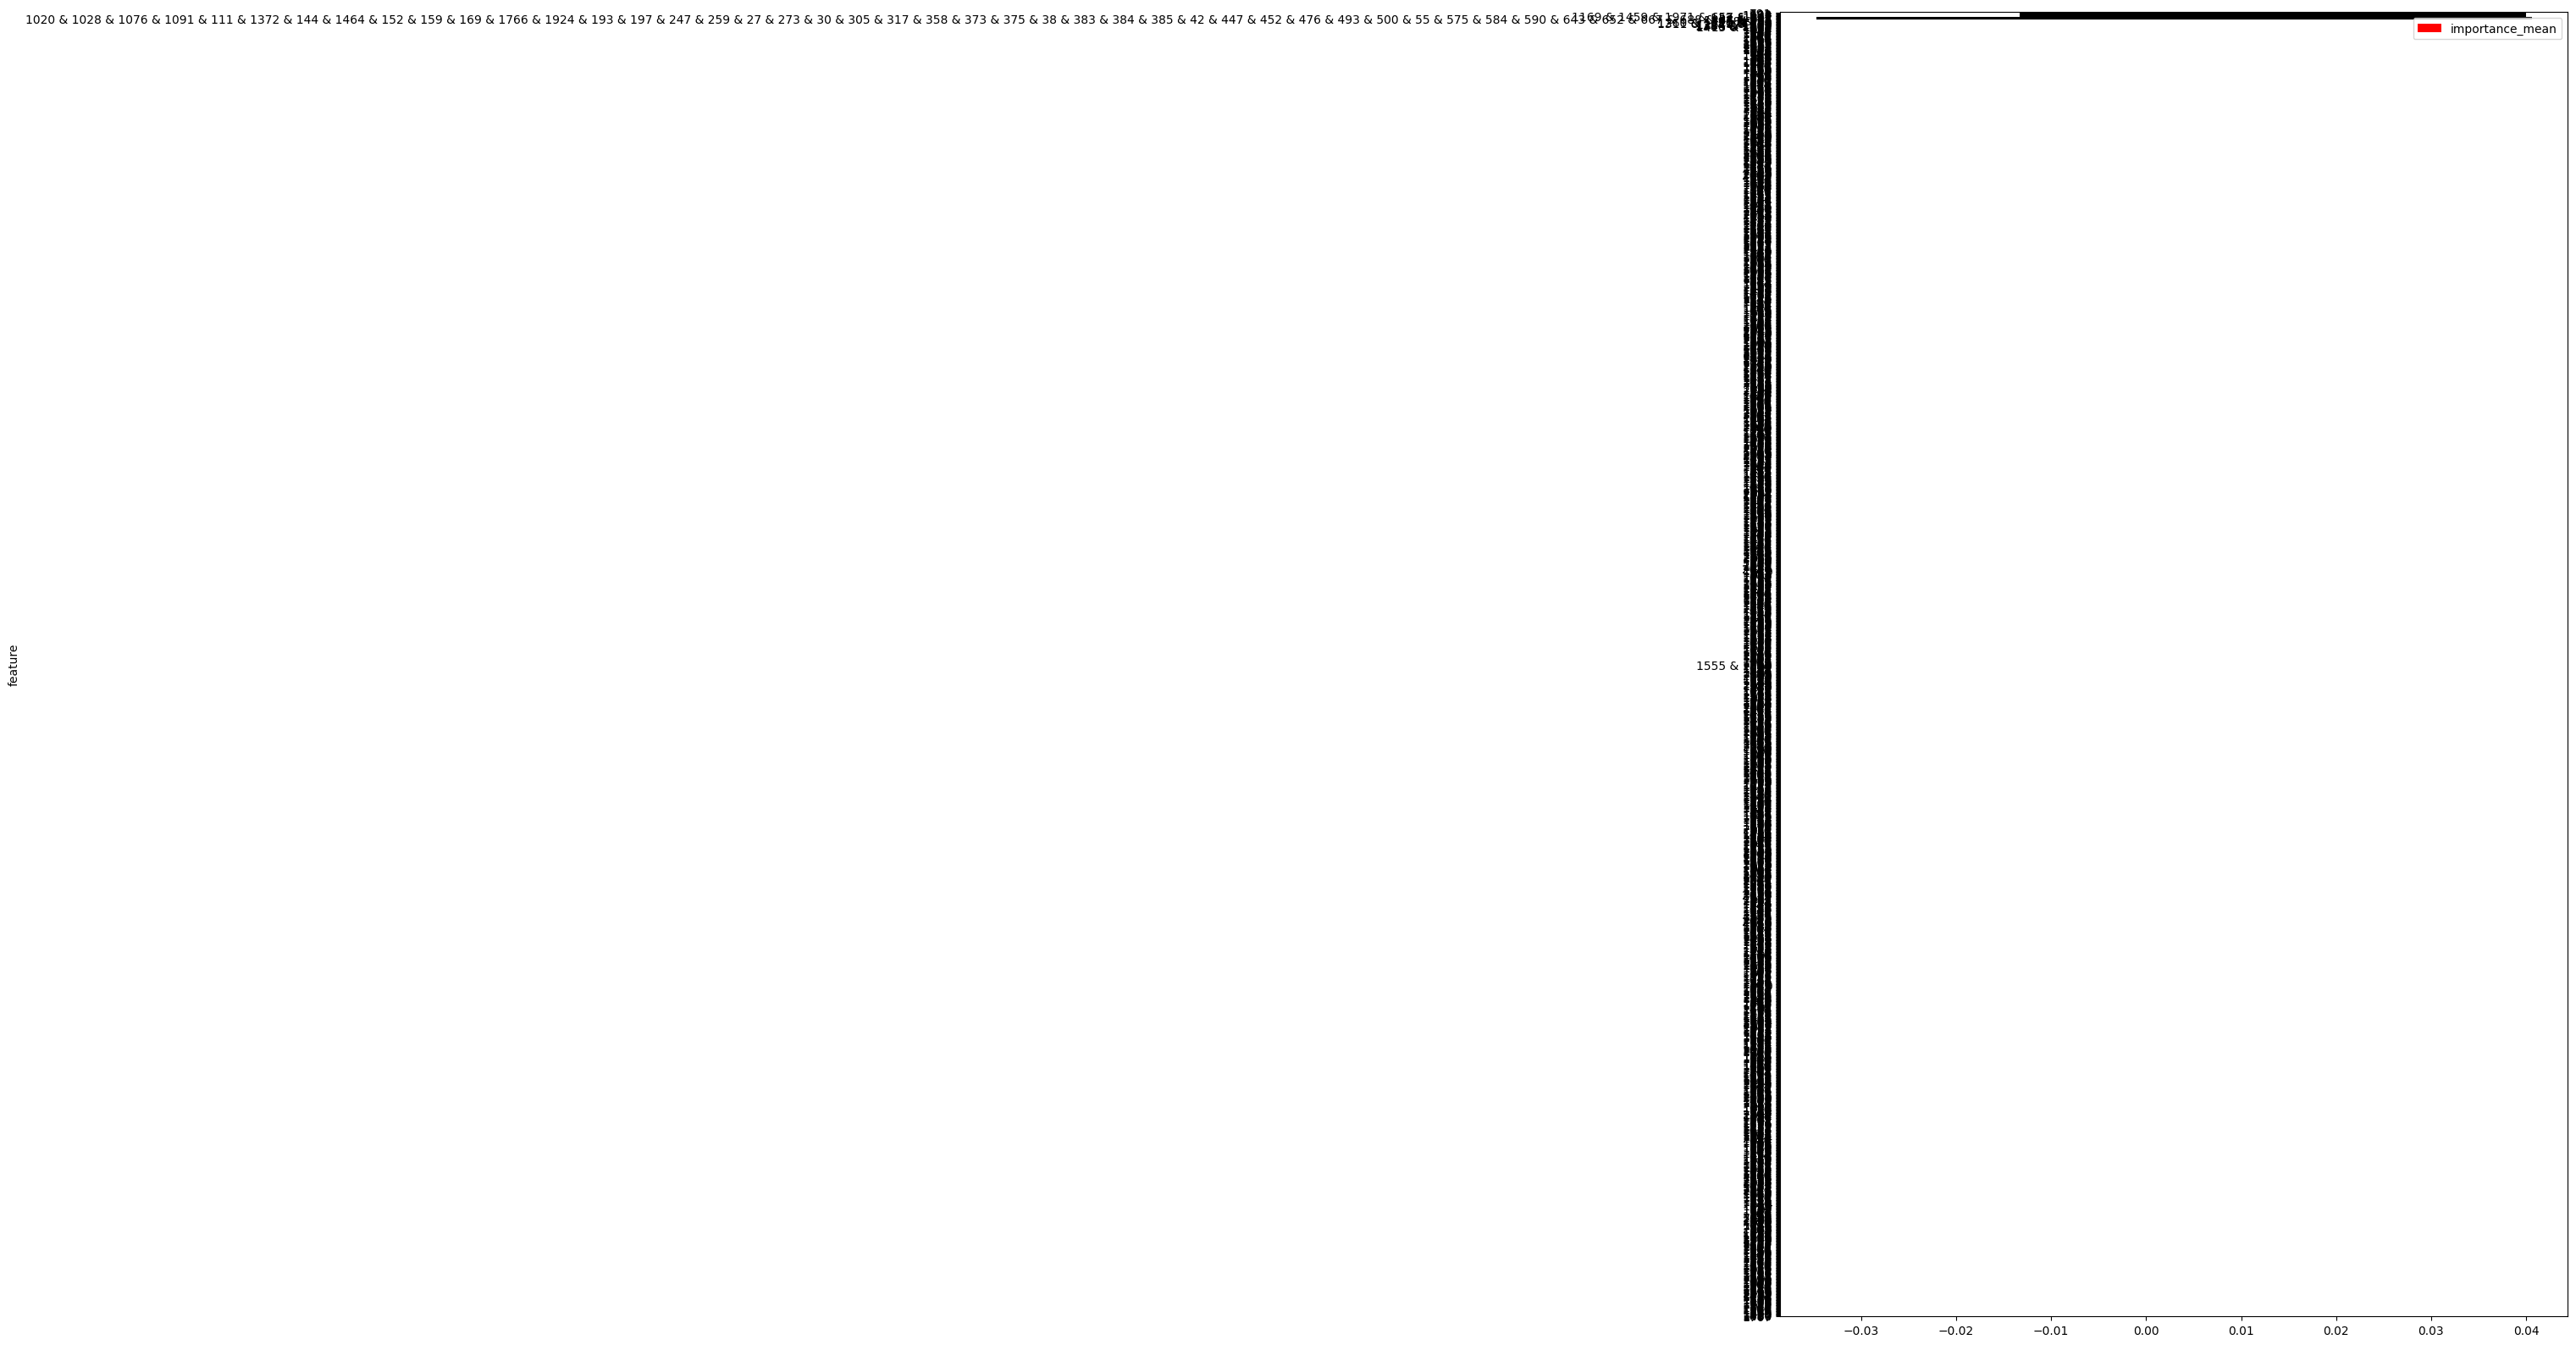

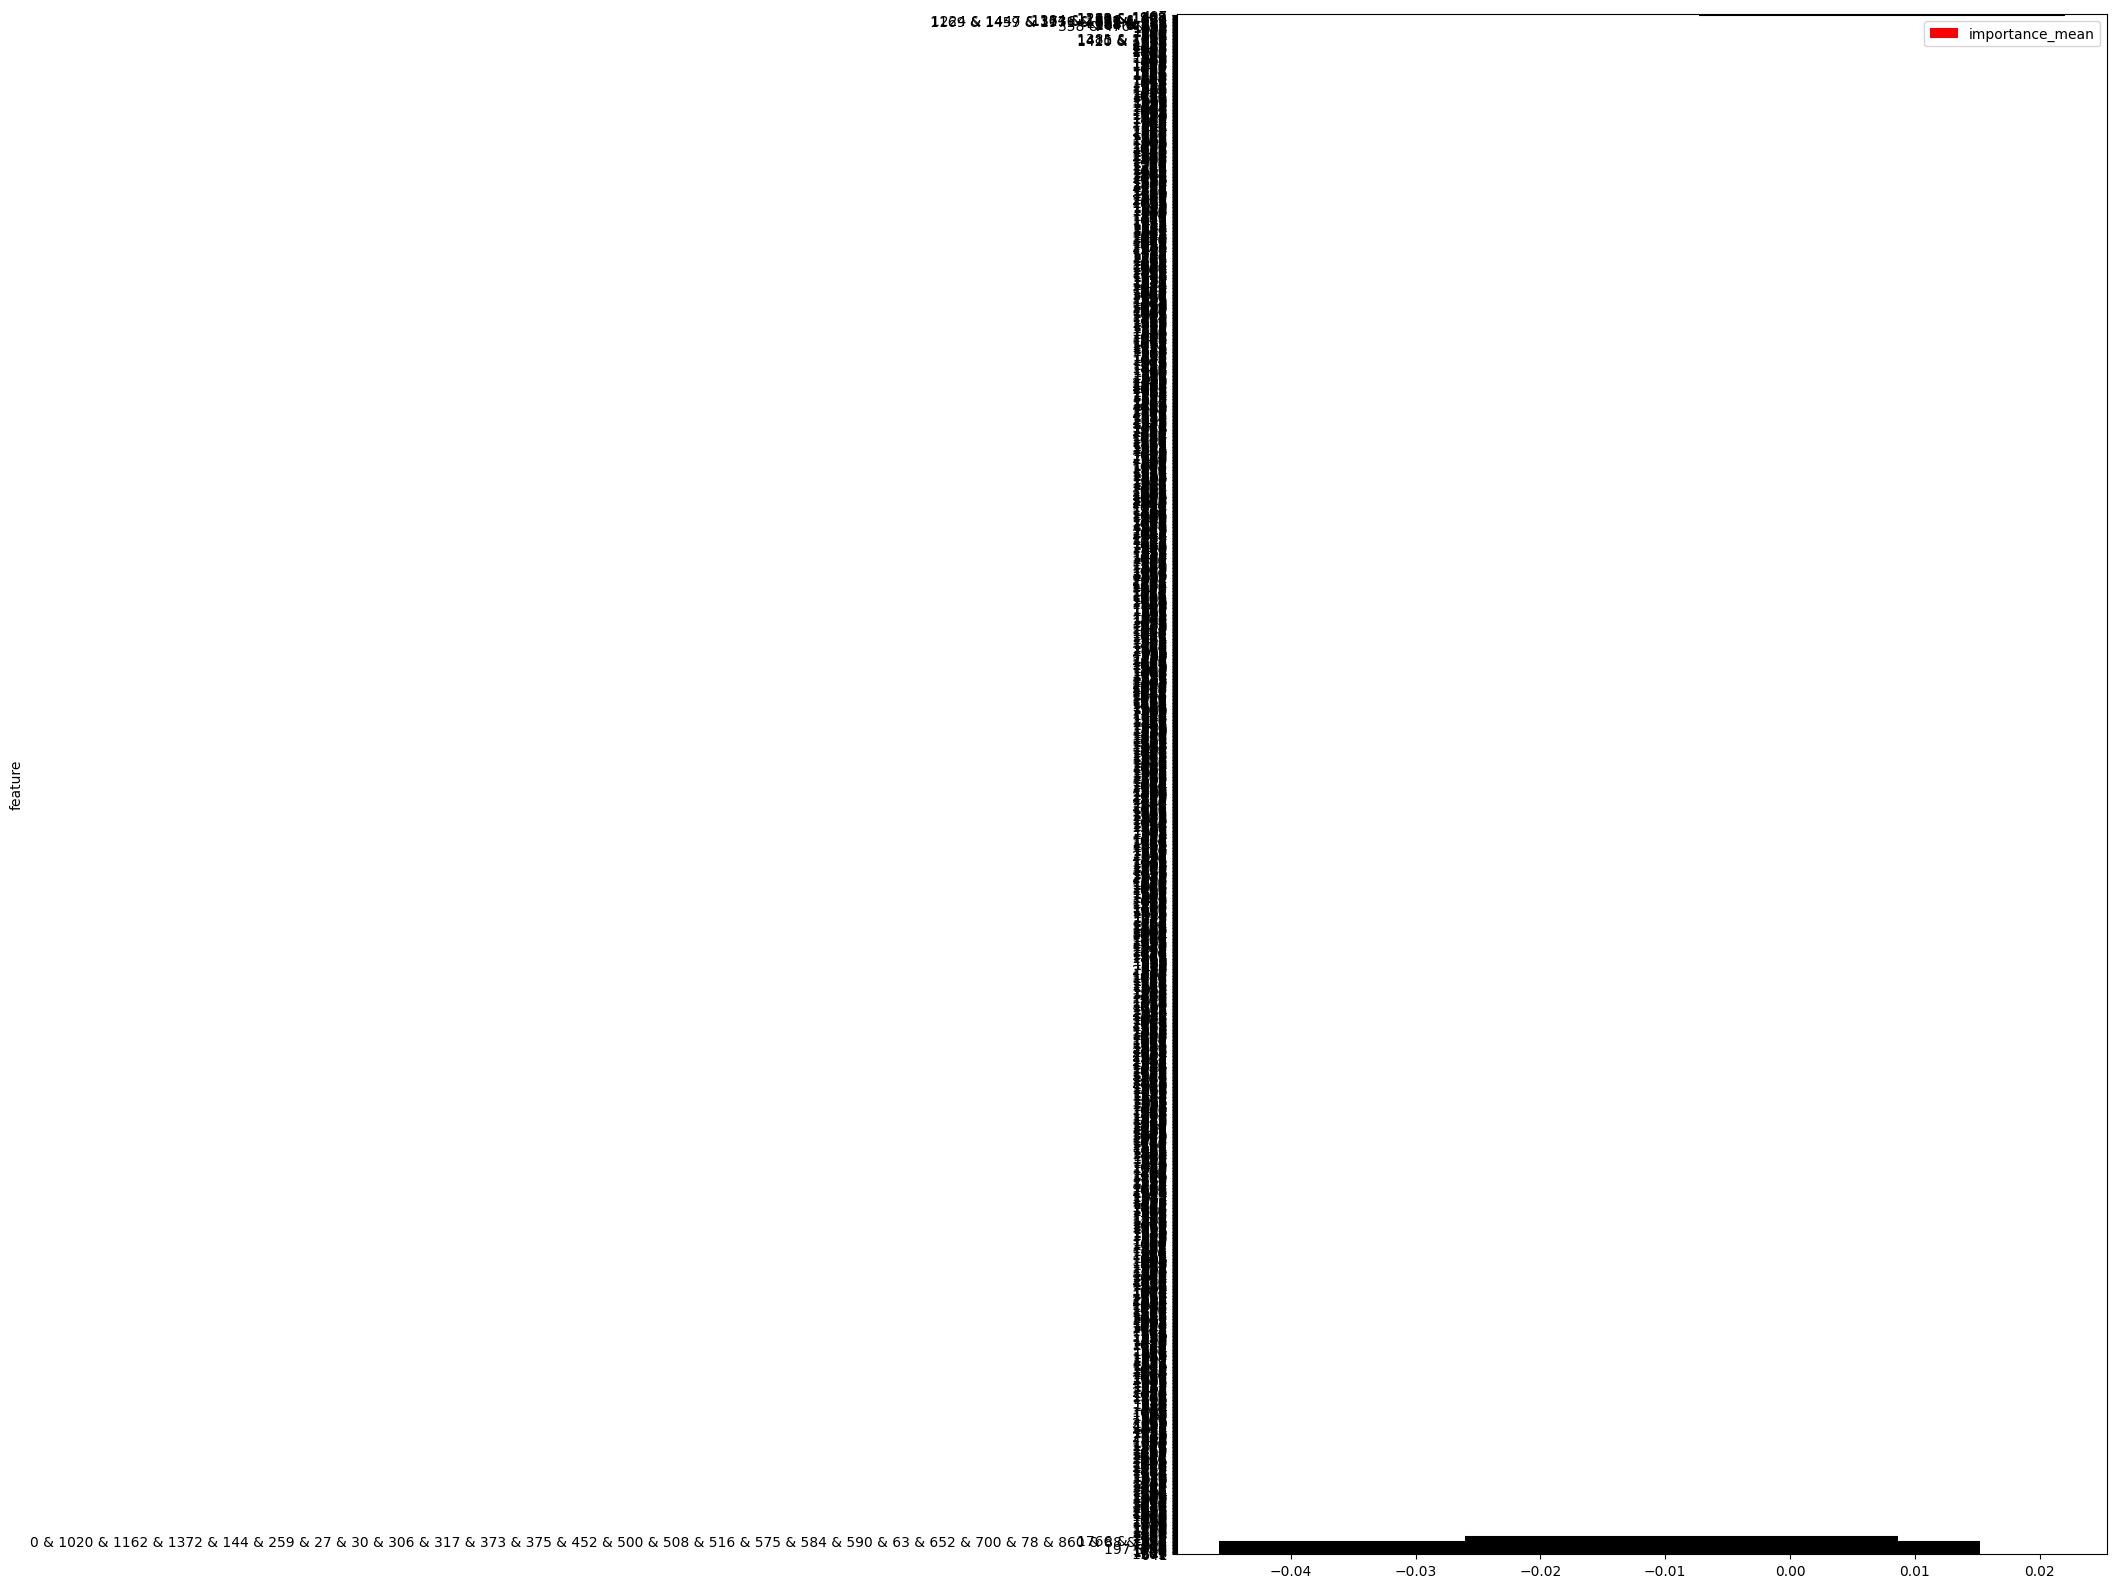

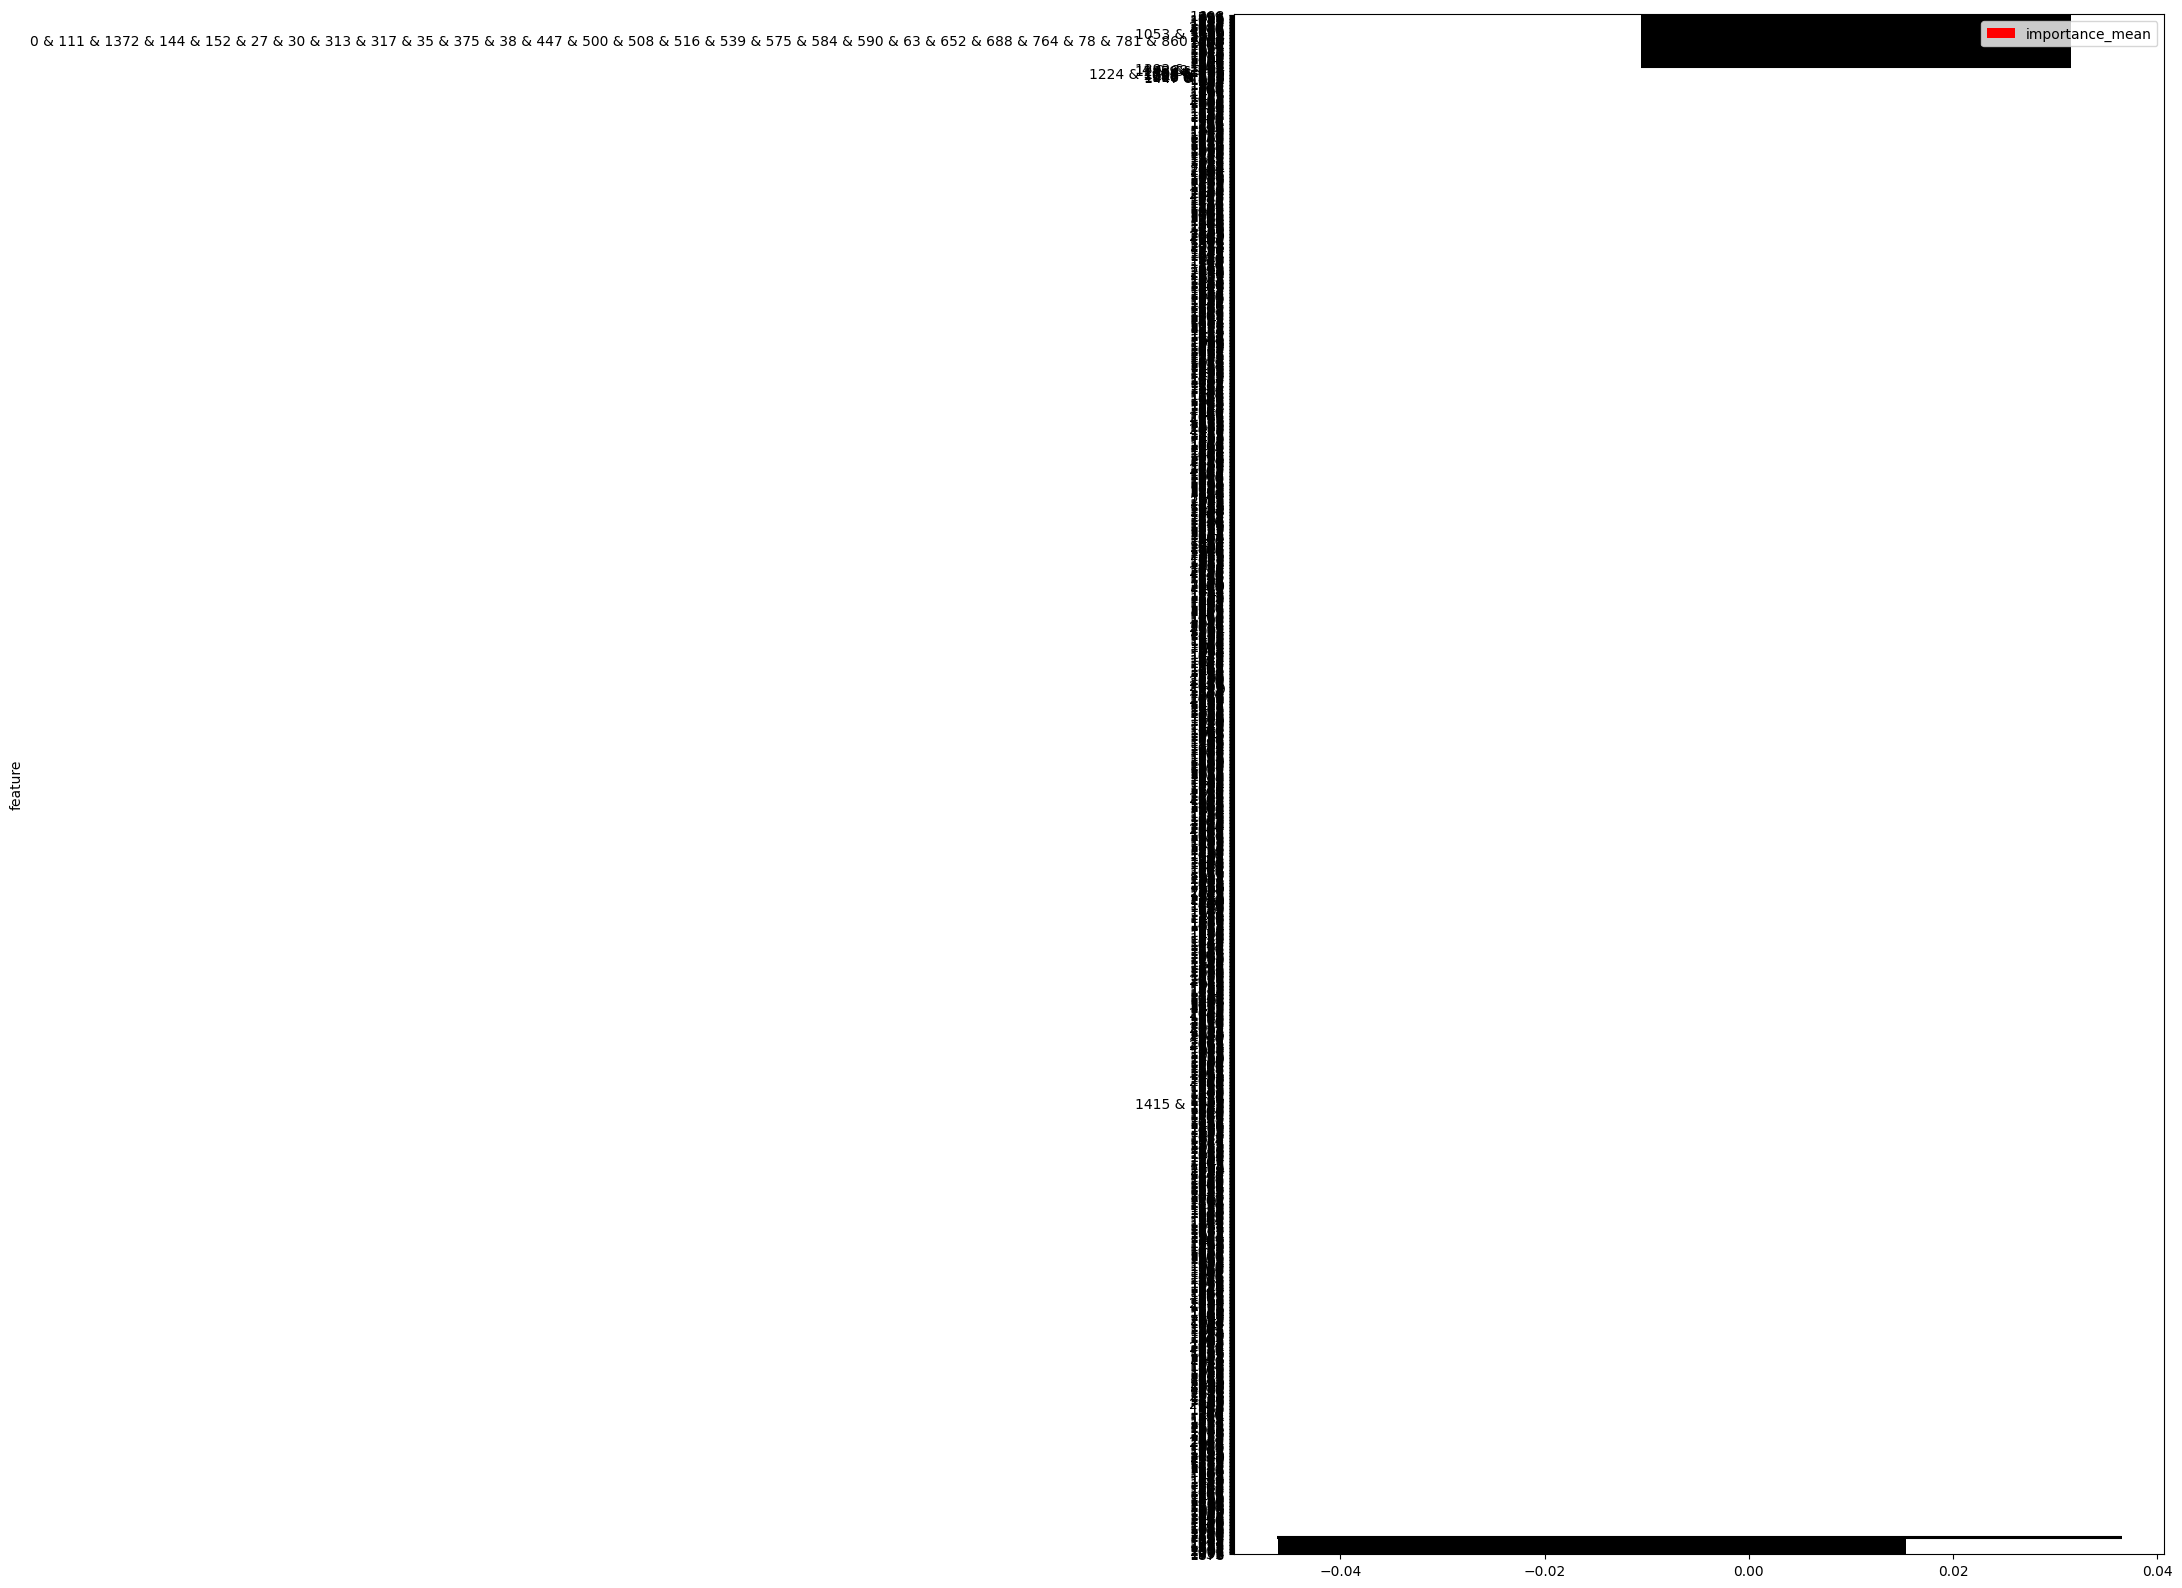

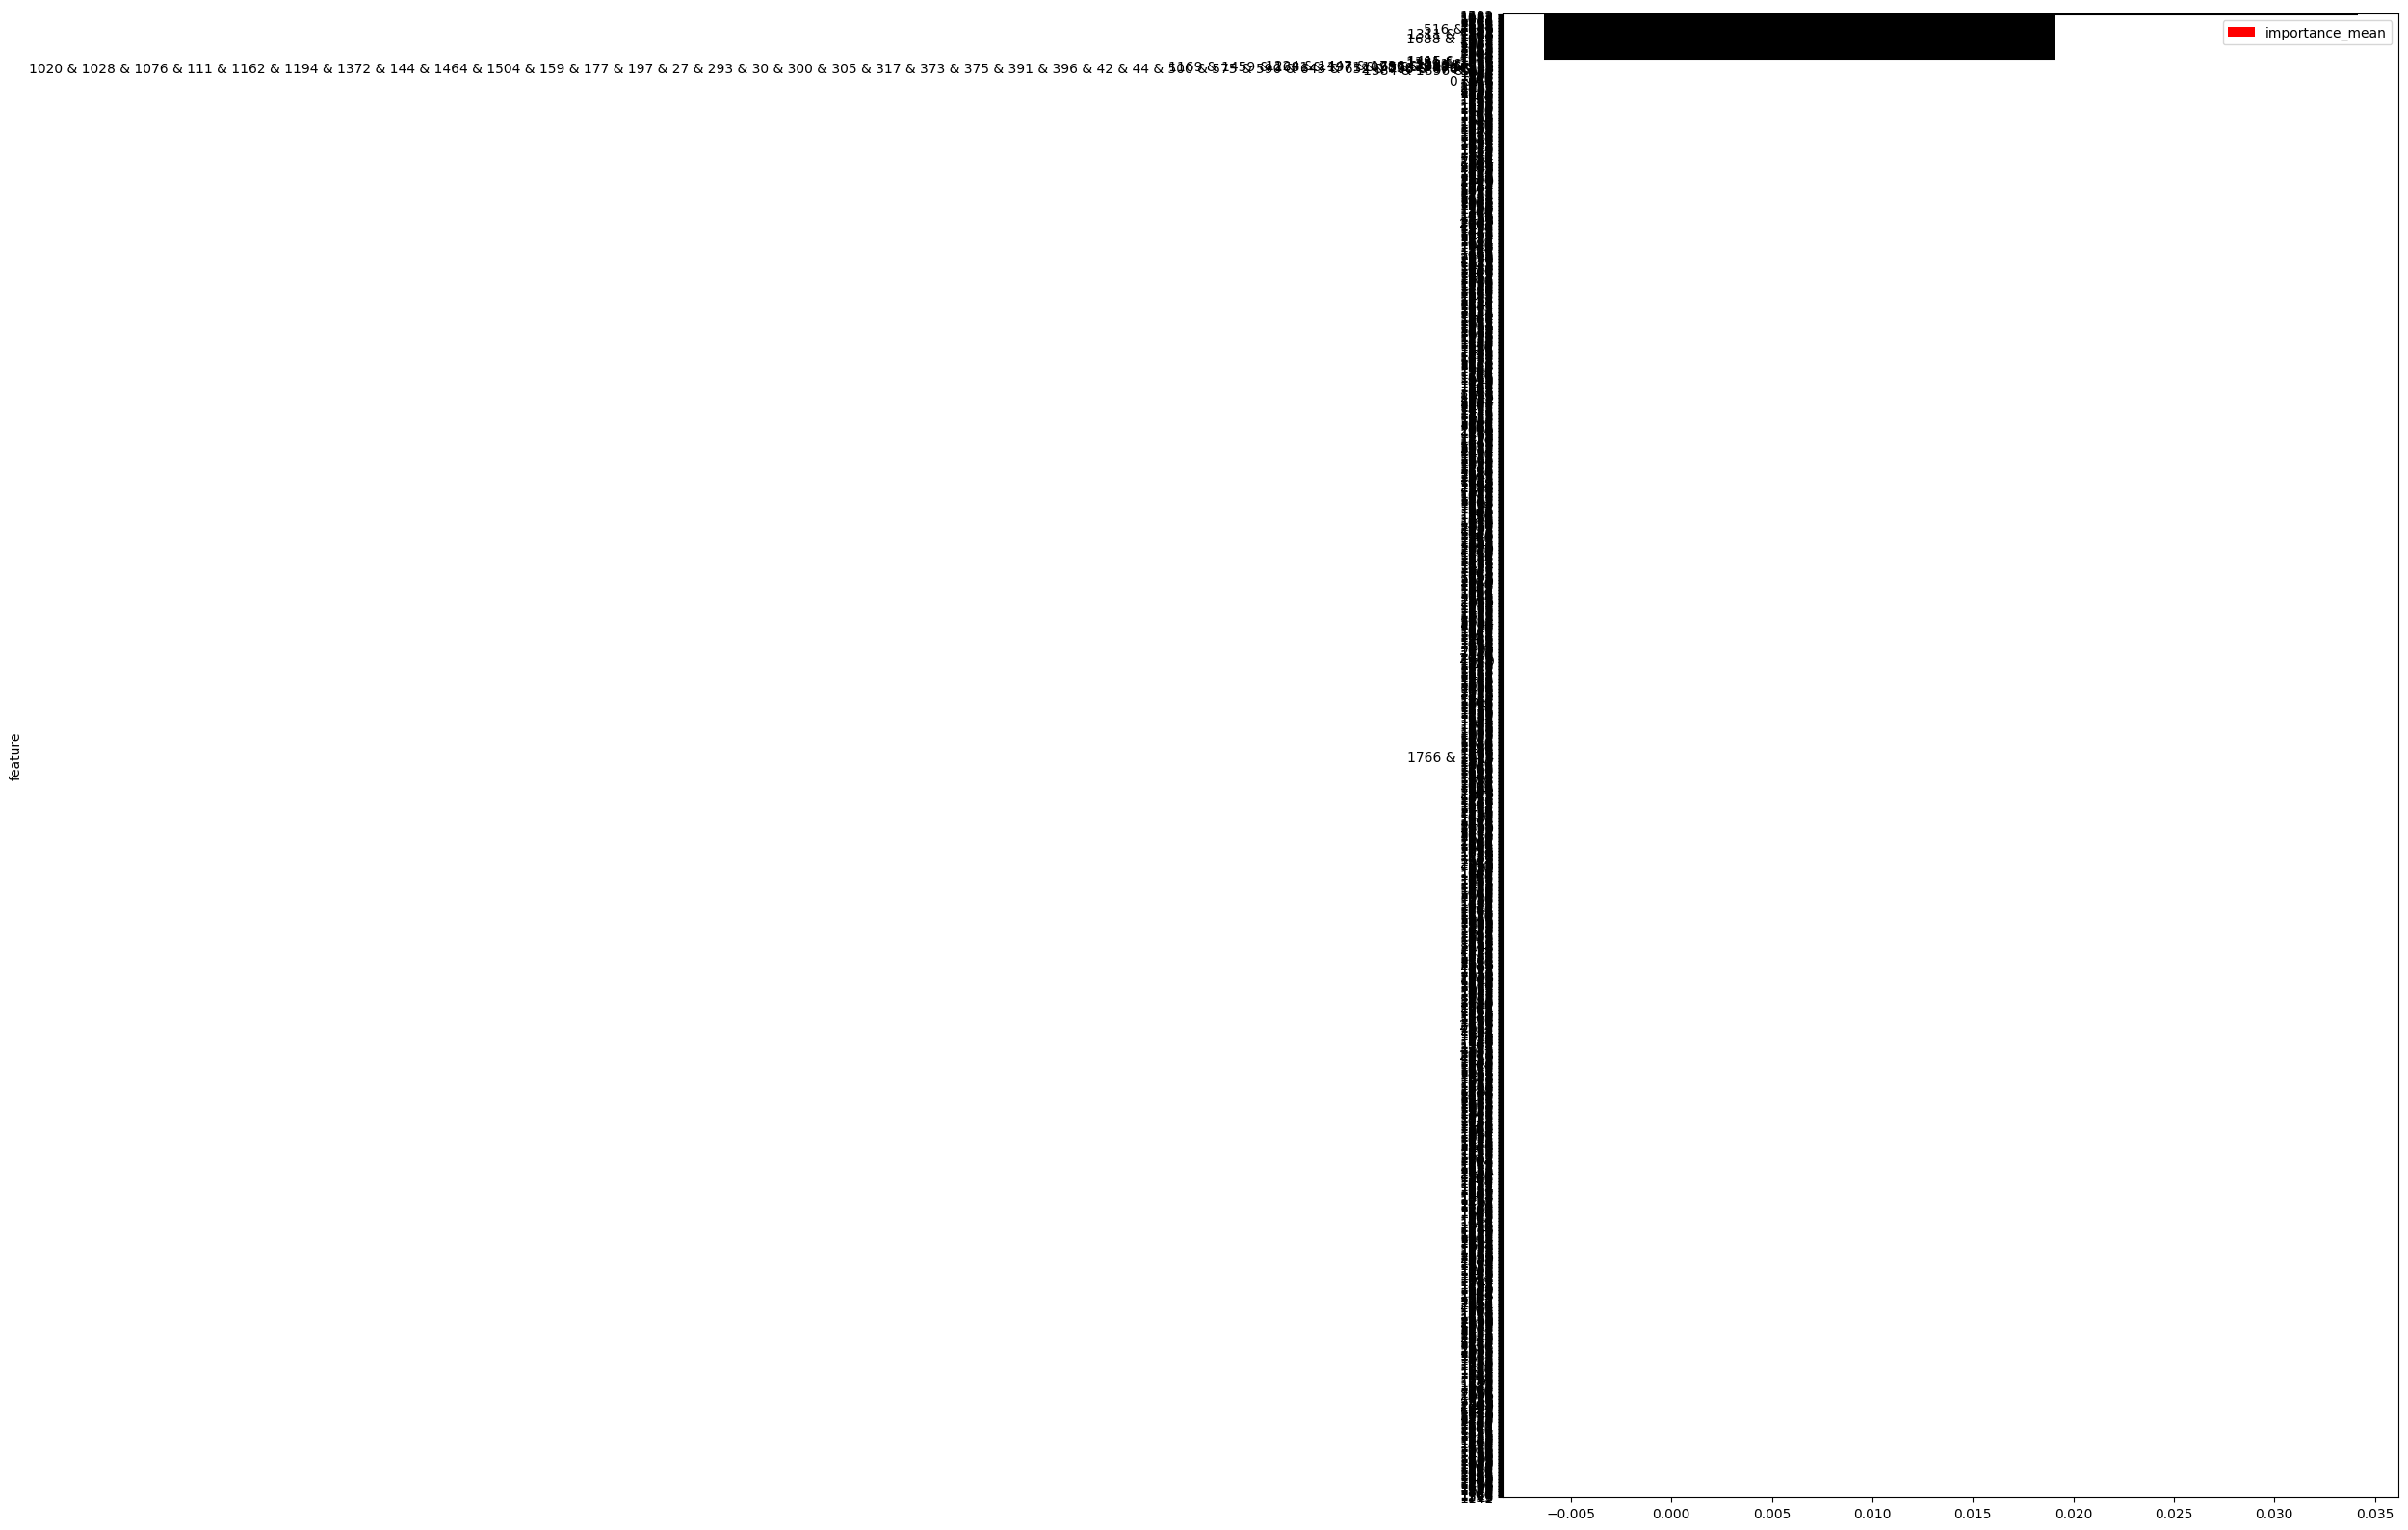

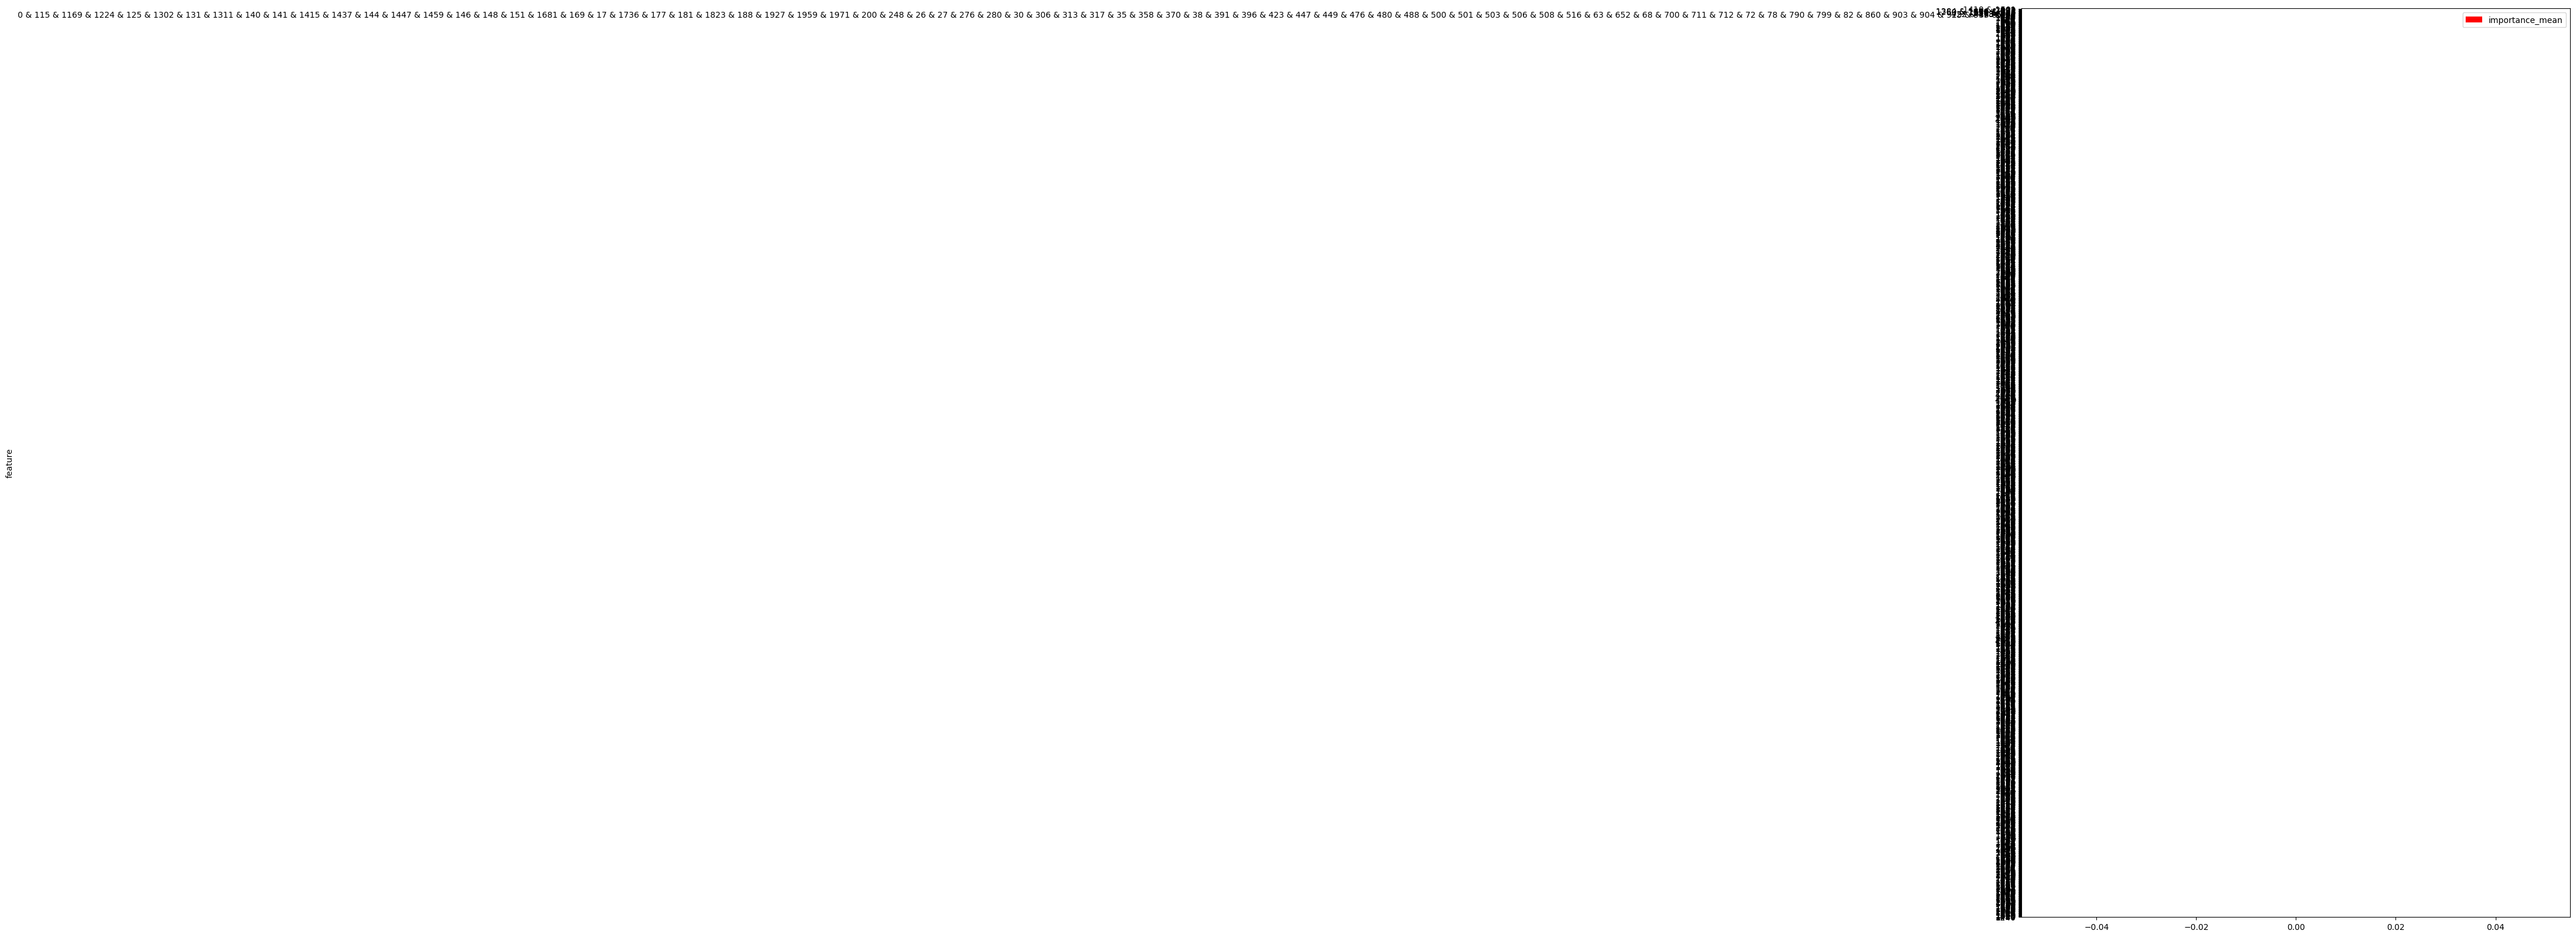

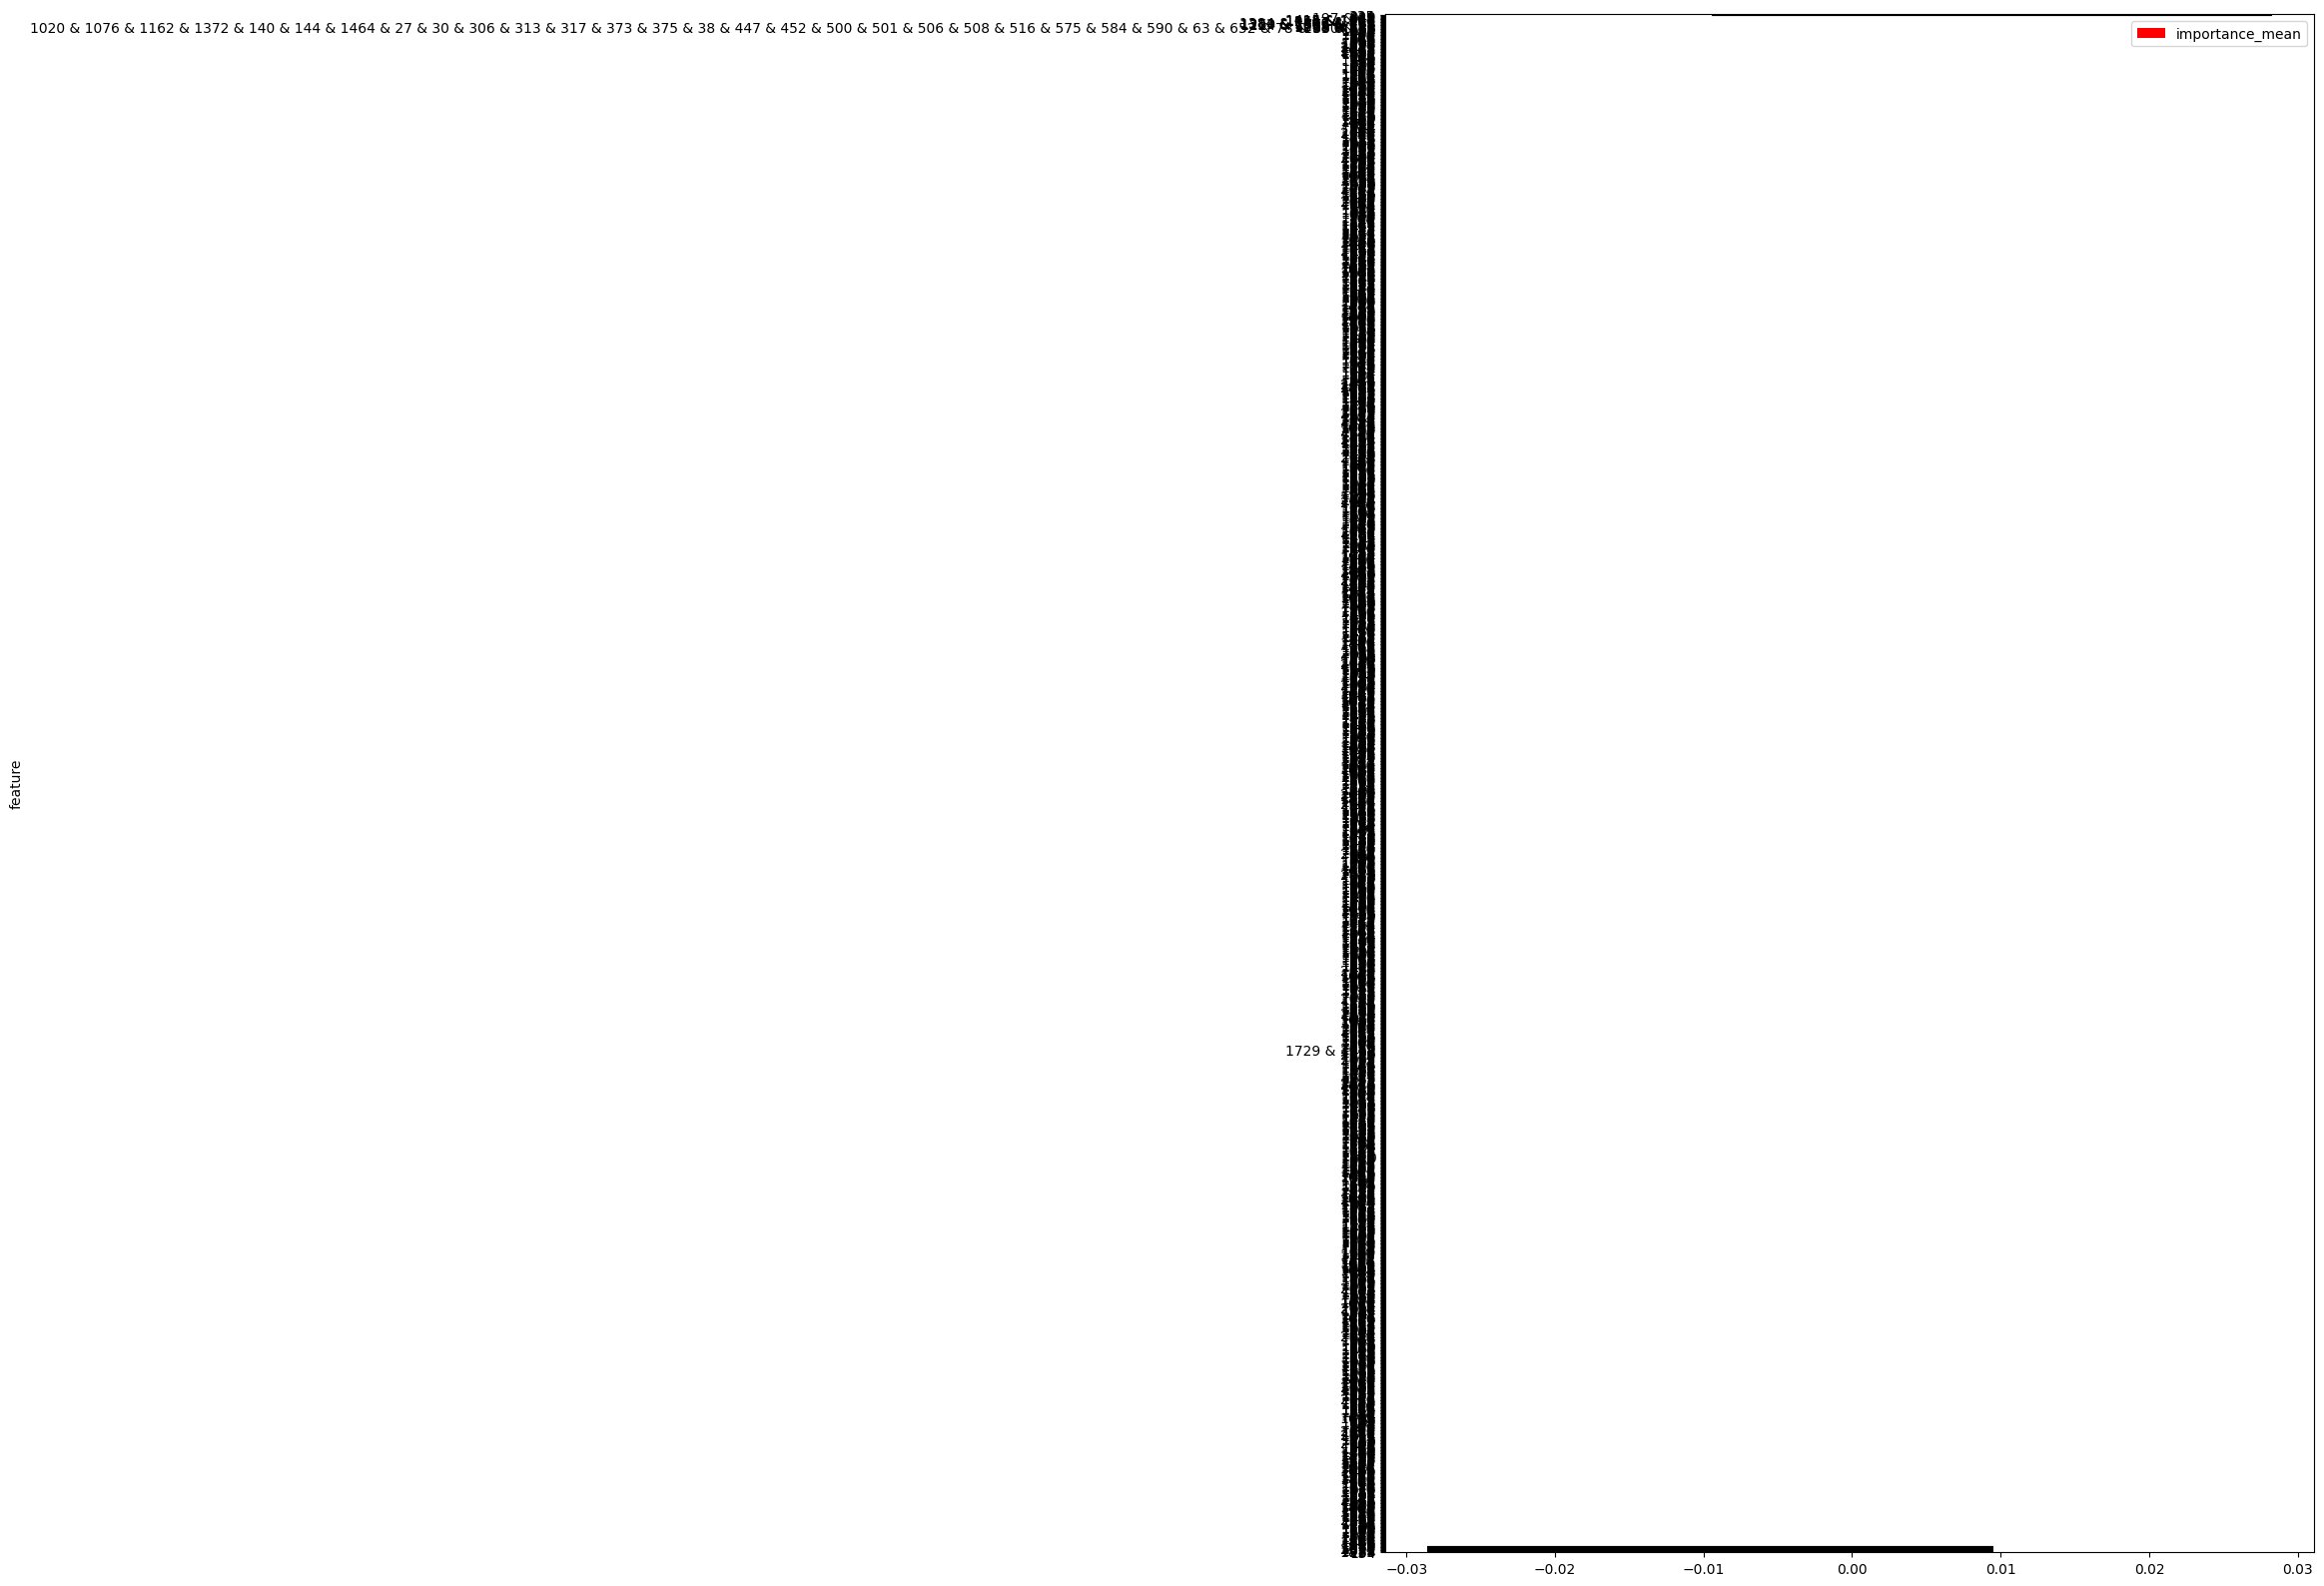

In [ ]:
BYOL-S_feature_names = [i for i in range(2048)]
BYOL-S_str_feature_names = [str(i) for i in range(2048)]

BYOL-S_fi_dict = {}

emotions = ['anger', 'fear', 'neutral', 'happiness', 'sadness', 'disgust']

for e in emotions:

  print(e)
  print('---------------------------------------------------------------------')
  print()

  BYOL-S_embeddings, BYOL-S_labels, BYOL-S_speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], embeddings_dict=BYOL-S_embeddings_dict, speakers_dict=BYOL-S_speakers_list_dict, num=45)

  trained_model, result = classification_pipeline(embeddings=BYOL-S_embeddings, speakers=BYOL-S_speakers, labels_list=BYOL-S_labels, feature_names=BYOL-S_feature_names)
  Performance['Hybrid_BYOL-S_2048'][e] = result

  fi = feature_importance_method(X=BYOL-S_embeddings, y=BYOL-S_labels, feature_names=BYOL-S_feature_names, trained_model=trained_model)
  BYOL-S_fi_dict[e] = [tup[0] for tup in fi]

  print()
  print()

In [ ]:
num_BYOL-S_features = {e: 1 for e in emotions}

def plot_top_performance(e, importance_dict):
  BYOL-S_embeddings, BYOL-S_labels, BYOL-S_speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], embeddings_dict=BYOL-S_embeddings_dict, speakers_dict=BYOL-S_speakers_list_dict, num=45)
  top_scores = []
  bottom_scores = []
  rest_scores = []

  for n in range(10, 1024, 10):

    top_features = importance_dict[e][:n]
    best_model, top_f1 = classification_pipeline(embeddings=BYOL-S_embeddings[:, top_features], speakers=BYOL-S_speakers, labels_list=BYOL-S_labels, feature_names=BYOL-S_feature_names)
    top_scores.append(top_f1)

    rest_features = importance_dict[e][n+1:]
    best_model, rest_f1 = classification_pipeline(embeddings=BYOL-S_embeddings[:, rest_features], speakers=BYOL-S_speakers, labels_list=BYOL-S_labels, feature_names=BYOL-S_feature_names)
    rest_scores.append(rest_f1)

    bottom_features = importance_dict[e][2048-n-1:]
    best_model, bottom_f1 = classification_pipeline(embeddings=BYOL-S_embeddings[:, bottom_features], speakers=BYOL-S_speakers, labels_list=BYOL-S_labels, feature_names=BYOL-S_feature_names)
    bottom_scores.append(bottom_f1)

  n_features = range(10, 1024, 10)
  fig, ax = plt.subplots()

  ax.plot(n_features, top_scores, label='Top dimensions')
  ax.plot(n_features, rest_scores, label='Rest dimensions')
  ax.plot(n_features, bottom_scores, label='Bottom dimensions')

  ax.set_xlabel('Number of dimensions')
  ax.set_ylabel('F1 score')
  ax.set_title(e)
  ax.legend()

  percentile = np.percentile(top_scores, 100)
  # ax.axhline(y=percentile, color='r')

  ax.set_ylim(0, 100)
  x_val = find_x_at_n_percentile(n_features, top_scores, 100)
  ax.scatter(x_val, percentile, marker='x', color='red')

  return x_val, percentile



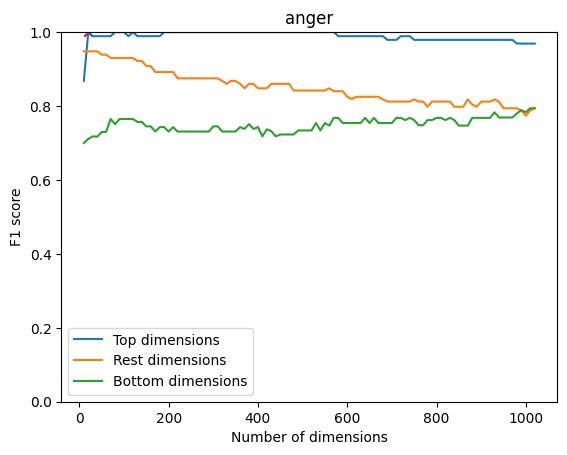

In [ ]:
emotions = ['anger', 'fear', 'neutral', 'happiness', 'sadness', 'disgust']

num_BYOL-S_features[emotions[0]], Performance['Hybrid_BYOL-S_top_features'][emotions[0]] = plot_top_performance(emotions[0], BYOL-S_fi_dict)


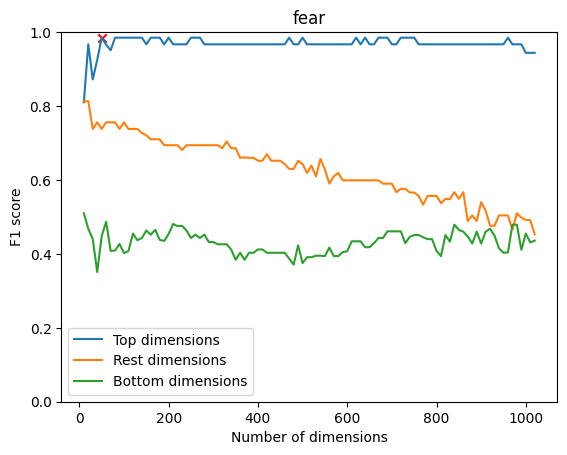

In [ ]:

num_BYOL-S_features[emotions[1]], Performance['Hybrid_BYOL-S_top_features'][emotions[1]]  = plot_top_performance(emotions[1], BYOL-S_fi_dict)


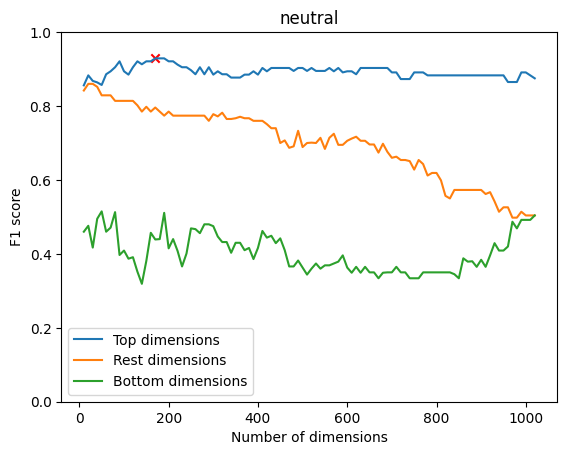

In [ ]:

num_BYOL-S_features[emotions[2]], Performance['Hybrid_BYOL-S_top_features'][emotions[2]] = plot_top_performance(emotions[2], BYOL-S_fi_dict)


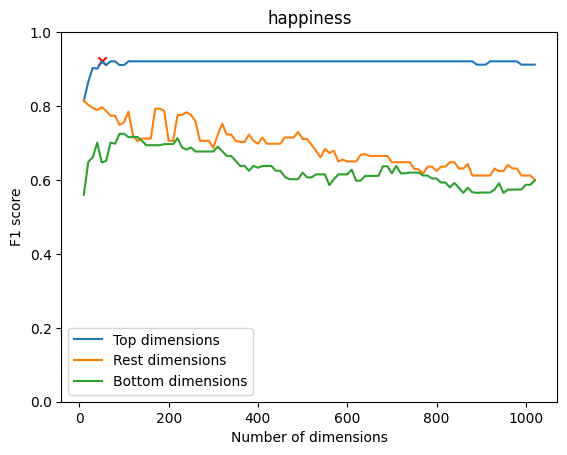

In [ ]:

num_BYOL-S_features[emotions[3]], Performance['Hybrid_BYOL-S_top_features'][emotions[3]] = plot_top_performance(emotions[3], BYOL-S_fi_dict)


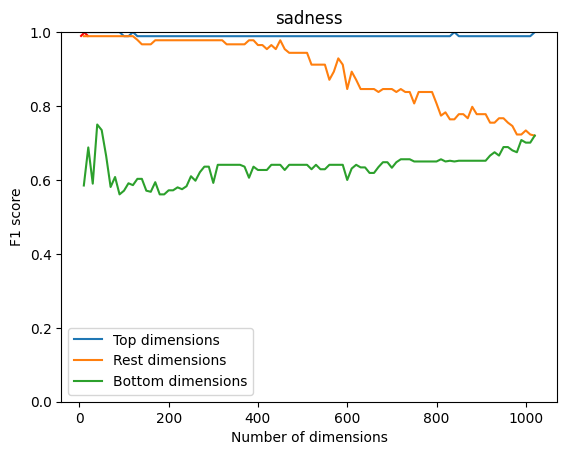

In [ ]:

num_BYOL-S_features[emotions[4]], Performance['Hybrid_BYOL-S_top_features'][emotions[4]] = plot_top_performance(emotions[4], BYOL-S_fi_dict)


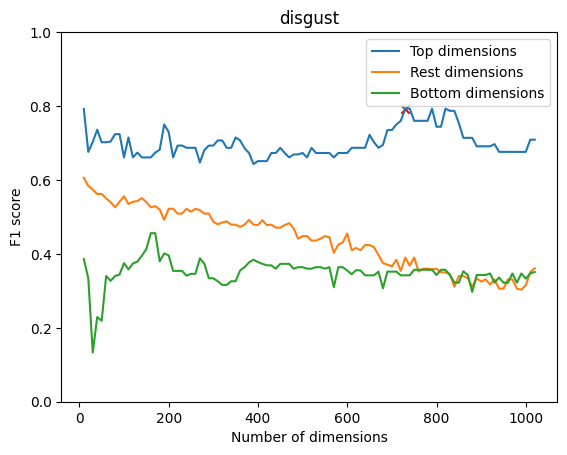

In [ ]:

num_BYOL-S_features[emotions[5]], Performance['Hybrid_BYOL-S_top_features'][emotions[5]] = plot_top_performance(emotions[5], BYOL-S_fi_dict)


In [ ]:
print(num_BYOL-S_features)


{'anger': 20, 'fear': 50, 'neutral': 170, 'happiness': 50, 'sadness': 10, 'disgust': 730}


# Predicting Functions

In [ ]:
# Defining a function for all steps
from sklearn.linear_model import Ridge

def prediction_pipeline(labeled_array, labels_list, regression_model, scoring='neg_root_mean_squared_error'):

  # Train Test Splitting
  X_train, X_test, y_train, y_test = train_test_split(
      labeled_array, labels_list, test_size=0.20)

  # Getting hyperparameters
  if regression_model == 'ridge':
    regressor = Ridge()
    parameters = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    result, p = get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring=scoring)

  return result, p


In [ ]:

# Defining a function for hyperparameter tuning and getting the accuracy on the test set
def get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring='neg_mean_squared_error'): # check scoring
  '''
  Splits into training and testing set with different speakers

  Parameters
  ------------
  X_train: torch tensor
    The normalised embeddings that will be used for training
  X_test: torch tensor
    The normalised embeddings that will be used for testing
  y_train: list
    The labels that will be used for training
  y_test: list
    The labels that will be used for testing
  classifier: object
    The instance of the classification model
  parameters: dictionary
    The dictionary of parameters for GridSearchCV

  Returns
  ------------
    The dictionary of the best hyperparameters

  '''

  # Define the pipeline
  pipe = Pipeline([
          ('scaler', StandardScaler()),
          ('model', regressor)
      ])

  grid = GridSearchCV(pipe, param_grid=parameters, cv=5, n_jobs=-1, scoring=scoring)
  grid.fit(X_train, y_train)

  y_pred = grid.predict(X_test)
  r_squared = r2_score(y_test, y_pred)
  pearson_correlation = np.corrcoef(y_test, y_pred)[0, 1]

  return r_squared, pearson_correlation

# Getting performance for top features

In [ ]:
predicted_df_dict = {}

def top_BYOL-S_predict_ege(e):

  en_errors_r_squared_top = []
  en_errors_r_squared_all = []
  pearson_corr_top = []
  pearson_corr_all = []

  BYOL-S_embeddings, BYOL-S_labels, BYOL-S_speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], embeddings_dict=BYOL-S_embeddings_dict, speakers_dict=BYOL-S_speakers_list_dict, num=45)
  ege_embeddings, ege_labels, ege_speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], embeddings_dict=eGeMAPS_embeddings_dict, speakers_dict=eGeMAPS_speakers_list_dict, num=45)

  top_features = BYOL-S_fi_dict[e][:num_BYOL-S_features[e]]
  all_features = BYOL-S_fi_dict[e][:]


  for i in tqdm(range(88)):

    en_r_squared_top, p_corr_top = prediction_pipeline(BYOL-S_embeddings[:, top_features], ege_embeddings[:,i], regression_model='ridge')
    en_errors_r_squared_top.append(np.round(en_r_squared_top, 3))
    pearson_corr_top.append(np.round(p_corr_top, 3))

    en_r_squared_all, p_corr_all = prediction_pipeline(BYOL-S_embeddings[:, all_features], ege_embeddings[:,i], regression_model='ridge')
    en_errors_r_squared_all.append(np.round(en_r_squared_all, 3))
    pearson_corr_all.append(np.round(p_corr_all, 3))

  prediction_metrics_dict = {'features':eGeMAPS_feature_names, 'pearson top':pearson_corr_top, 'R2 top':en_errors_r_squared_top, 'pearson all': pearson_corr_all, 'R2 all':en_errors_r_squared_all}

  return prediction_metrics_dict


In [ ]:
df = pd.DataFrame(top_BYOL-S_predict_ege(emotions[0]))
sorted_df = df.sort_values(by='pearson top', ascending=False)
predicted_df_dict[emotions[0]] = sorted_df


100%|██████████| 88/88 [00:28<00:00,  3.06it/s]


In [ ]:
sorted_df.head(10)

features  pearson top  R2 top  \
62                    slopeV0-500_sma3nz_amean        0.899   0.801   
60               hammarbergIndexV_sma3nz_amean        0.896   0.791   
58                    alphaRatioV_sma3nz_amean        0.869   0.718   
0            F0semitoneFrom27.5Hz_sma3nz_amean        0.872   0.714   
70                         mfcc2V_sma3nz_amean        0.875   0.698   
24                            mfcc2_sma3_amean        0.829   0.675   
4   F0semitoneFrom27.5Hz_sma3nz_percentile80.0        0.826   0.663   
78                   slopeUV0-500_sma3nz_amean        0.812   0.658   
38                 logRelF0-H1-A3_sma3nz_amean        0.789   0.600   
86                 StddevUnvoicedSegmentLength        0.811   0.580   

    pearson all  R2 all  
62        0.963   0.927  
60        0.991   0.958  
58        0.909   0.823  
0         0.976   0.938  
70        0.959   0.913  
24        0.933   0.869  
4         0.994   0.976  
78        0.951   0.904  
38        0.948   0.884  
86        0.924   0.853

In [ ]:
df = pd.DataFrame(top_BYOL-S_predict_ege(emotions[1]))
sorted_df = df.sort_values(by='pearson top', ascending=False)
predicted_df_dict[emotions[1]] = sorted_df


100%|██████████| 88/88 [00:27<00:00,  3.20it/s]


In [ ]:
sorted_df.head(10)

features  pearson top  R2 top  \
70                         mfcc2V_sma3nz_amean        0.924   0.847   
62                    slopeV0-500_sma3nz_amean        0.925   0.791   
0            F0semitoneFrom27.5Hz_sma3nz_amean        0.897   0.772   
28                            mfcc4_sma3_amean        0.867   0.728   
4   F0semitoneFrom27.5Hz_sma3nz_percentile80.0        0.896   0.724   
72                         mfcc3V_sma3nz_amean        0.854   0.698   
24                            mfcc2_sma3_amean        0.839   0.655   
2   F0semitoneFrom27.5Hz_sma3nz_percentile20.0        0.811   0.652   
74                         mfcc4V_sma3nz_amean        0.843   0.648   
3   F0semitoneFrom27.5Hz_sma3nz_percentile50.0        0.767   0.580   

    pearson all  R2 all  
70        0.954   0.881  
62        0.955   0.906  
0         0.984   0.965  
28        0.924   0.810  
4         0.979   0.909  
72        0.935   0.821  
24        0.953   0.881  
2         0.955   0.883  
74        0.873   0.747  
3         0.957   0.887

In [ ]:
df = pd.DataFrame(top_BYOL-S_predict_ege(emotions[2]))
sorted_df = df.sort_values(by='pearson top', ascending=False)
predicted_df_dict[emotions[2]] = sorted_df


100%|██████████| 88/88 [00:32<00:00,  2.73it/s]


In [ ]:
sorted_df.head(10)

features  pearson top  R2 top  \
0            F0semitoneFrom27.5Hz_sma3nz_amean        0.965   0.932   
3   F0semitoneFrom27.5Hz_sma3nz_percentile50.0        0.967   0.922   
4   F0semitoneFrom27.5Hz_sma3nz_percentile80.0        0.948   0.890   
70                         mfcc2V_sma3nz_amean        0.922   0.850   
58                    alphaRatioV_sma3nz_amean        0.960   0.849   
2   F0semitoneFrom27.5Hz_sma3nz_percentile20.0        0.915   0.833   
34                       HNRdBACF_sma3nz_amean        0.948   0.832   
68                         mfcc1V_sma3nz_amean        0.912   0.820   
24                            mfcc2_sma3_amean        0.913   0.793   
26                            mfcc3_sma3_amean        0.906   0.778   

    pearson all  R2 all  
0         0.987   0.959  
3         0.942   0.830  
4         0.978   0.955  
70        0.888   0.779  
58        0.913   0.815  
2         0.891   0.769  
34        0.961   0.913  
68        0.955   0.895  
24        0.968   0.910  
26        0.937   0.838

In [ ]:
df = pd.DataFrame(top_BYOL-S_predict_ege(emotions[3]))
sorted_df = df.sort_values(by='pearson top', ascending=False)
predicted_df_dict[emotions[3]] = sorted_df


100%|██████████| 88/88 [00:28<00:00,  3.07it/s]


In [ ]:
sorted_df.head(10)

features  pearson top  R2 top  \
28                            mfcc4_sma3_amean        0.954   0.890   
58                    alphaRatioV_sma3nz_amean        0.901   0.796   
4   F0semitoneFrom27.5Hz_sma3nz_percentile80.0        0.903   0.787   
60               hammarbergIndexV_sma3nz_amean        0.943   0.773   
0            F0semitoneFrom27.5Hz_sma3nz_amean        0.860   0.723   
74                         mfcc4V_sma3nz_amean        0.859   0.723   
45       F1amplitudeLogRelF0_sma3nz_stddevNorm        0.902   0.705   
72                         mfcc3V_sma3nz_amean        0.847   0.704   
62                    slopeV0-500_sma3nz_amean        0.899   0.703   
68                         mfcc1V_sma3nz_amean        0.845   0.702   

    pearson all  R2 all  
28        0.976   0.935  
58        0.903   0.805  
4         0.990   0.976  
60        0.912   0.773  
0         0.988   0.974  
74        0.959   0.914  
45        0.848   0.664  
72        0.972   0.925  
62        0.983   0.963  
68        0.970   0.930

In [ ]:
df = pd.DataFrame(top_BYOL-S_predict_ege(emotions[4]))
sorted_df = df.sort_values(by='pearson top', ascending=False)
predicted_df_dict[emotions[4]] = sorted_df


100%|██████████| 88/88 [00:27<00:00,  3.24it/s]


In [ ]:
sorted_df.head(10)

features  pearson top  R2 top  pearson all  \
62               slopeV0-500_sma3nz_amean        0.885   0.752        0.965   
58               alphaRatioV_sma3nz_amean        0.883   0.744        0.960   
85              MeanUnvoicedSegmentLength        0.870   0.723        0.836   
57  F3amplitudeLogRelF0_sma3nz_stddevNorm        0.887   0.684        0.929   
68                    mfcc1V_sma3nz_amean        0.866   0.683        0.884   
78              slopeUV0-500_sma3nz_amean        0.831   0.681        0.932   
24                       mfcc2_sma3_amean        0.829   0.660        0.893   
74                    mfcc4V_sma3nz_amean        0.816   0.611        0.889   
22                       mfcc1_sma3_amean        0.826   0.610        0.950   
50       F2amplitudeLogRelF0_sma3nz_amean        0.811   0.606        0.966   

    R2 all  
62   0.928  
58   0.917  
85   0.611  
57   0.765  
68   0.777  
78   0.861  
24   0.770  
74   0.771  
22   0.871  
50   0.932

In [ ]:
df = pd.DataFrame(top_BYOL-S_predict_ege(emotions[5]))
sorted_df = df.sort_values(by='pearson top', ascending=False)
predicted_df_dict[emotions[5]] = sorted_df


100%|██████████| 88/88 [00:32<00:00,  2.70it/s]


In [ ]:
sorted_df.head(10)

features  pearson top  R2 top  \
0            F0semitoneFrom27.5Hz_sma3nz_amean        0.985   0.961   
4   F0semitoneFrom27.5Hz_sma3nz_percentile80.0        0.978   0.953   
3   F0semitoneFrom27.5Hz_sma3nz_percentile50.0        0.974   0.940   
70                         mfcc2V_sma3nz_amean        0.967   0.914   
2   F0semitoneFrom27.5Hz_sma3nz_percentile20.0        0.959   0.913   
62                    slopeV0-500_sma3nz_amean        0.943   0.887   
24                            mfcc2_sma3_amean        0.950   0.860   
28                            mfcc4_sma3_amean        0.961   0.853   
74                         mfcc4V_sma3nz_amean        0.941   0.847   
56            F3amplitudeLogRelF0_sma3nz_amean        0.932   0.839   

    pearson all  R2 all  
0         0.987   0.963  
4         0.978   0.956  
3         0.950   0.895  
70        0.934   0.857  
2         0.904   0.811  
62        0.944   0.867  
24        0.960   0.900  
28        0.958   0.893  
74        0.928   0.836  
56        0.879   0.770

In [ ]:
new_line = '\n'

def summary_table(e, df1):

  df2 = predicted_df_dict[e]

  stats_dict = {'number of features':[], 'pearson top':[], 'R2 top':[], 'pearson all':[], 'R2 all':[]}
  df = df1.copy(deep=True)
  df.index = range(len(df))

  for i in range(10):

    all_features = df1.iloc[i, 0].split(' & ')
    # print(all_features)

    r_squared_values_top = []
    r_squared_values_all = []
    pearson_correlations_top = []
    pearson_correlations_all = []

    for f in all_features:
      # print(f)
      matching_row = df2[df2['features'] == f]
      r_squared_values_top.append( matching_row['R2 top'])
      r_squared_values_all.append( matching_row['R2 all'])
      pearson_correlations_top.append( matching_row['pearson top'])
      pearson_correlations_all.append( matching_row['pearson all'])

    stats_dict['number of features'].append(len(r_squared_values_top))

    if len(r_squared_values_top)>1:
      stats_dict['R2 top'].append(f"{np.round(np.mean(r_squared_values_top), 3)}{new_line}[{np.min(r_squared_values_top)} - {np.max(r_squared_values_top)}]")
      stats_dict['R2 all'].append(f"{np.round(np.mean(r_squared_values_all), 3)}{new_line}[{np.min(r_squared_values_all)} - {np.max(r_squared_values_all)}]")
      stats_dict['pearson top'].append(f"{np.round(np.mean(pearson_correlations_top), 3)}{new_line}[{np.min(pearson_correlations_top)} - {np.max(pearson_correlations_top)}]")
      stats_dict['pearson all'].append(f"{np.round(np.mean(pearson_correlations_all), 3)}{new_line}[{np.min(pearson_correlations_all)} - {np.max(pearson_correlations_all)}]")
    else:
      stats_dict['R2 top'].append(str(np.mean(r_squared_values_top)))
      stats_dict['R2 all'].append(str(np.mean(r_squared_values_all)))
      stats_dict['pearson top'].append(str(np.mean(pearson_correlations_top)))
      stats_dict['pearson all'].append(str(np.mean(pearson_correlations_all)))

  stats_df = pd.DataFrame(stats_dict)
  summary_df = pd.concat([df, stats_df], axis=1)
  summary_df.round(3)

  return summary_df


In [ ]:
e = emotions[0]
df = summary_table(e=e, df1=lofo_dict[e].iloc[:, :2].head(10))
df

feature  importance_mean  \
0  F0semitoneFrom27.5Hz_sma3nz_amean & F0semitone...         0.080298   
1                   loudness_sma3_stddevFallingSlope         0.060000   
2                   slopeV500-1500_sma3nz_stddevNorm         0.055612   
3                           mfcc1V_sma3nz_stddevNorm         0.053318   
4  logRelF0-H1-H2_sma3nz_amean & logRelF0-H1-H2_s...         0.049592   
5                              mfcc1_sma3_stddevNorm         0.045965   
6                       StddevVoicedSegmentLengthSec         0.045965   
7                           equivalentSoundLevel_dBp         0.045965   
8                        spectralFluxUV_sma3nz_amean         0.045318   
9                      F2frequency_sma3nz_stddevNorm         0.039298   

   number of features             pearson top                   R2 top  \
0                  30  0.697\n[0.108 - 0.899]  0.417\n[-0.644 - 0.801]   
1                   1                   0.357                    0.076   
2                   1                   0.279                    0.053   
3                   1                   0.356                     0.08   
4                   2  0.502\n[0.401 - 0.604]   0.154\n[0.124 - 0.185]   
5                   1                   0.085                   -4.059   
6                   1                   0.319                    0.101   
7                   1                   0.184                   -0.122   
8                   1                   0.689                    0.323   
9                   1                   0.183                   -0.371   

              pearson all                  R2 all  
0   0.92\n[0.434 - 0.994]  0.827\n[0.141 - 0.976]  
1                   0.312                  -0.158  
2                   0.227                  -0.287  
3                   0.057                  -1.684  
4  0.644\n[0.431 - 0.857]  0.408\n[0.116 - 0.701]  
5                  -0.044                  -0.391  
6                   0.382                  -0.102  
7                   0.805                   0.624  
8                   0.921                   0.771  
9                   0.806                   0.623

In [ ]:
e = emotions[1]
df = summary_table(e=e, df1=lofo_dict[e].iloc[:, :2].head(10))
df

feature  importance_mean  \
0                     loudness_sma3_meanFallingSlope         0.033251   
1                           F1bandwidth_sma3nz_amean         0.032987   
2  alphaRatioUV_sma3nz_amean & hammarbergIndexUV_...         0.023729   
3             F0semitoneFrom27.5Hz_sma3nz_stddevNorm         0.021952   
4  loudness_sma3_amean & loudness_sma3_percentile...         0.021393   
5  F1amplitudeLogRelF0_sma3nz_amean & F1amplitude...         0.018869   
6           F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2         0.016914   
7                           loudness_sma3_stddevNorm         0.016130   
8                        spectralFluxUV_sma3nz_amean         0.014025   
9       F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope         0.012382   

   number of features             pearson top                  R2 top  \
0                   1                   0.536                   0.221   
1                   1                   0.562                  -0.146   
2                   2  0.734\n[0.704 - 0.764]  0.302\n[0.252 - 0.352]   
3                   1                   0.554                   0.217   
4                   3  0.587\n[0.511 - 0.649]   0.276\n[0.224 - 0.34]   
5                   8   0.654\n[0.542 - 0.81]  0.363\n[0.277 - 0.561]   
6                   1                   0.503                   0.236   
7                   1                   0.764                   0.433   
8                   1                   0.798                   0.511   
9                   1                  -0.004                   -0.32   

              pearson all                  R2 all  
0                   0.798                   0.562  
1                   0.756                   0.531  
2   0.89\n[0.875 - 0.905]  0.752\n[0.712 - 0.791]  
3                   0.668                   0.402  
4  0.768\n[0.574 - 0.916]  0.508\n[0.198 - 0.713]  
5  0.916\n[0.819 - 0.971]  0.769\n[0.433 - 0.922]  
6                   0.659                   0.403  
7                   0.878                   0.741  
8                   0.814                   0.653  
9                    0.11                  -0.012

In [ ]:
e = emotions[2]
df = summary_table(e=e, df1=lofo_dict[e].iloc[:, :2].head(10))
df

feature  importance_mean  \
0  F1amplitudeLogRelF0_sma3nz_amean & F1amplitude...         0.103138   
1     F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope         0.061464   
2                           F1bandwidth_sma3nz_amean         0.043552   
3  F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope & ...         0.042437   
4                           F2bandwidth_sma3nz_amean         0.039762   
5                           mfcc4V_sma3nz_stddevNorm         0.036190   
6                   loudness_sma3_stddevFallingSlope         0.033182   
7  F0semitoneFrom27.5Hz_sma3nz_amean & F0semitone...         0.025914   
8  F1frequency_sma3nz_amean & F2frequency_sma3nz_...         0.023805   
9                               VoicedSegmentsPerSec         0.021190   

   number of features             pearson top                     R2 top  \
0                   6  0.816\n[0.702 - 0.877]     0.544\n[0.259 - 0.696]   
1                   1                  -0.087                     -0.486   
2                   1                    0.42                      0.121   
3                   2   0.222\n[0.22 - 0.225]  -3.288\n[-5.968 - -0.608]   
4                   1                   0.681                      0.443   
5                   1                  -0.226                   -157.744   
6                   1                   0.228                     -0.049   
7                   4  0.949\n[0.915 - 0.967]     0.894\n[0.833 - 0.932]   
8                   3  0.698\n[0.566 - 0.823]     0.467\n[0.296 - 0.675]   
9                   1                   0.552                      0.268   

              pearson all                       R2 all  
0  0.925\n[0.889 - 0.957]       0.825\n[0.764 - 0.888]  
1                  -0.174                      -10.629  
2                    0.67                        0.405  
3   0.41\n[0.236 - 0.583]  -11.058\n[-14.997 - -7.118]  
4                   0.694                        0.433  
5                  -0.193                      -98.204  
6                   0.597                        0.354  
7   0.95\n[0.891 - 0.987]       0.878\n[0.769 - 0.959]  
8  0.845\n[0.808 - 0.875]       0.688\n[0.587 - 0.762]  
9                   0.775                        0.473

In [ ]:
e = emotions[3]
df = summary_table(e=e, df1=lofo_dict[e].iloc[:, :2].head(10))
df

feature  importance_mean  \
0  F0semitoneFrom27.5Hz_sma3nz_amean & F0semitone...         0.143452   
1                      jitterLocal_sma3nz_stddevNorm         0.049608   
2                         HNRdBACF_sma3nz_stddevNorm         0.045048   
3                           mfcc3V_sma3nz_stddevNorm         0.030110   
4                       loudness_sma3_percentile20.0         0.028787   
5                        shimmerLocaldB_sma3nz_amean         0.025732   
6                   shimmerLocaldB_sma3nz_stddevNorm         0.025481   
7                              mfcc3_sma3_stddevNorm         0.024913   
8                      F2bandwidth_sma3nz_stddevNorm         0.022506   
9                      slopeV0-500_sma3nz_stddevNorm         0.020264   

   number of features              pearson top                  R2 top  \
0                  29  0.739\n[-0.083 - 0.954]  -0.36\n[-26.18 - 0.89]   
1                   1                    0.706                   0.481   
2                   1                    0.209                  -0.678   
3                   1                   -0.449                  -4.499   
4                   1                   -0.315                  -0.304   
5                   1                    0.714                   0.428   
6                   1                    -0.28                  -0.395   
7                   1                    0.424                  -1.417   
8                   1                     0.06                  -0.258   
9                   1                    0.026                  -0.467   

               pearson all                    R2 all  
0  0.866\n[-0.558 - 0.991]  -1.089\n[-48.71 - 0.978]  
1                    0.367                     0.019  
2                    0.606                     0.299  
3                    0.183                    -2.352  
4                    0.833                      0.62  
5                    0.847                     0.706  
6                    0.211                    -0.109  
7                    0.345                   -10.392  
8                    0.384                     0.105  
9                     0.18                    -3.337

In [ ]:
e = emotions[4]
df = summary_table(e=e, df1=lofo_dict[e].iloc[:, :2].head(10))
df

feature  importance_mean  \
0  F1amplitudeLogRelF0_sma3nz_amean & F1amplitude...         0.083006   
1                      slopeV0-500_sma3nz_stddevNorm         0.053609   
2                       slopeUV500-1500_sma3nz_amean         0.050350   
3  F1frequency_sma3nz_amean & F2frequency_sma3nz_...         0.045751   
4  spectralFluxUV_sma3nz_amean & spectralFluxV_sm...         0.037016   
5                        slopeV500-1500_sma3nz_amean         0.037016   
6       F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope         0.037016   
7                       StddevVoicedSegmentLengthSec         0.037016   
8                        logRelF0-H1-H2_sma3nz_amean         0.024029   
9                           mfcc2V_sma3nz_stddevNorm         0.015238   

   number of features             pearson top                     R2 top  \
0                  22  0.773\n[0.516 - 0.905]    0.521\n[-0.145 - 0.752]   
1                   1                    0.58                       0.33   
2                   1                    0.34                     -0.187   
3                   3  0.579\n[0.424 - 0.765]    0.181\n[-0.043 - 0.546]   
4                   3  0.225\n[0.069 - 0.407]  -0.143\n[-0.189 - -0.064]   
5                   1                   0.475                      0.118   
6                   1                   0.199                     -0.303   
7                   1                   0.364                      0.111   
8                   1                   0.297                      0.057   
9                   1                   0.286                     -0.353   

              pearson all                  R2 all  
0  0.893\n[0.623 - 0.974]  0.757\n[0.339 - 0.937]  
1                   0.063                  -6.729  
2                   0.772                   0.533  
3  0.738\n[0.687 - 0.821]  0.488\n[0.404 - 0.641]  
4  0.843\n[0.818 - 0.886]  0.667\n[0.619 - 0.744]  
5                   0.714                   0.398  
6                    0.19                  -1.591  
7                   0.628                   0.367  
8                   0.791                   0.495  
9                   -0.15                  -1.044

In [ ]:
e = emotions[5]
df = summary_table(e=e, df1=lofo_dict[e].iloc[:, :2].head(10))
df

feature  importance_mean  \
0  F0semitoneFrom27.5Hz_sma3nz_amean & F0semitone...         0.042660   
1                      F2frequency_sma3nz_stddevNorm         0.032090   
2                           F3bandwidth_sma3nz_amean         0.030111   
3                       slopeUV500-1500_sma3nz_amean         0.023868   
4                     loudness_sma3_meanFallingSlope         0.019307   
5                         HNRdBACF_sma3nz_stddevNorm         0.019131   
6                   loudness_sma3_stddevFallingSlope         0.019131   
7  loudness_sma3_amean & loudness_sma3_pctlrange0...         0.017899   
8  spectralFluxV_sma3nz_stddevNorm & spectralFlux...         0.009350   
9                           mfcc2V_sma3nz_stddevNorm         0.008874   

   number of features             pearson top                  R2 top  \
0                  17  0.917\n[0.804 - 0.985]  0.769\n[0.125 - 0.961]   
1                   1                   0.523                   0.269   
2                   1                   0.159                  -0.283   
3                   1                   0.628                    0.34   
4                   1                   0.689                    0.14   
5                   1                    0.33                   0.006   
6                   1                   0.526                    0.16   
7                   4   0.63\n[0.512 - 0.697]  0.332\n[0.125 - 0.435]   
8                   2  0.812\n[0.812 - 0.813]  0.649\n[0.641 - 0.657]   
9                   1                   0.062                   -0.08   

              pearson all                   R2 all  
0  0.894\n[0.648 - 0.987]  0.245\n[-8.604 - 0.963]  
1                   0.738                    0.485  
2                   0.526                   -0.197  
3                   0.831                    0.569  
4                   0.801                    0.575  
5                   0.678                    0.352  
6                   0.121                   -0.758  
7  0.714\n[0.471 - 0.821]  0.393\n[-0.029 - 0.595]  
8  0.782\n[0.762 - 0.801]   0.579\n[0.527 - 0.631]  
9                   0.048                   -0.155

# Performance Summary

In [ ]:
df = pd.DataFrame(Performance)
new_column_names = {'eGeMAPS': 'eGeMAPS', 'Hybrid_BYOL-S_2048': 'hybrid BYOL-S (all)', 'Hybrid_BYOL-S_top_features': 'hybrid BYOL-S (top)'}
df = df.rename(columns=new_column_names)
df.round(2)
df

egemaps  hybrid BYOLS (all)  hybrid BYOLS (top)
anger        0.914               0.948               1.000
fear         0.532               0.795               0.985
neutral      0.881               0.864               0.929
happiness    0.765               0.826               0.921
sadness      0.892               0.989               1.000
disgust      0.513               0.602               0.793